# Imports

In [1]:
import os
import librosa
import numpy as np
import soundfile
import IPython
import shutil
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
from imutils import paths
from tqdm import tqdm

from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data parsing

In [2]:
import os
import shutil
import subprocess

def download_and_extract_librispeech(destination_folder="/kaggle/working"):

    librispeech_url = "http://openslr.elda.org/resources/12/dev-clean.tar.gz"
    librispeech_tar = os.path.join(destination_folder, "dev-clean.tar.gz")
    clean_speech_folder = os.path.join(destination_folder, "clean_speech")

    subprocess.run(["wget", librispeech_url, "-O", librispeech_tar])
    subprocess.run(["tar", "-xvf", librispeech_tar, "-C", destination_folder])
    
    os.makedirs(clean_speech_folder, exist_ok=True)

    for root, _, files in os.walk(os.path.join(destination_folder, "LibriSpeech/dev-clean")):
        for file in files:
            if file.endswith(".flac"):
                src = os.path.join(root, file)
                dest = os.path.join(clean_speech_folder, file)
                shutil.copy2(src, dest)

    shutil.rmtree(os.path.join(destination_folder, "LibriSpeech"))
    print(f"Clean speech files saved to {clean_speech_folder}")


def download_and_extract_esc50(destination_folder="/kaggle/working"):
    esc50_url = "https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master"
    esc50_zip = os.path.join(destination_folder, "ESC-50-master.zip")
    noise_folder = os.path.join(destination_folder, "noise")

    subprocess.run(["wget", esc50_url, "-O", esc50_zip])
    subprocess.run(["unzip", esc50_zip, "-d", destination_folder])

    os.makedirs(noise_folder, exist_ok=True)
    for root, _, files in os.walk(os.path.join(destination_folder, "ESC-50-master/audio")):
        for file in files:
            if file.endswith(".wav"):
                src = os.path.join(root, file)
                dest = os.path.join(noise_folder, file)
                shutil.copy2(src, dest)

    shutil.rmtree(os.path.join(destination_folder, "ESC-50-master"))

    print(f"Noise files saved to {noise_folder}")

In [3]:
download_and_extract_librispeech()
download_and_extract_esc50()

Clean speech files saved to /kaggle/working/clean_speech
Noise files saved to /kaggle/working/noise


In [4]:
count_clean = 0
duration_clean = 0
duration_noise = 0
sample_rate=8000

for i in os.listdir('/kaggle/working/clean_speech'):
  count_clean += 1
  y,sr = librosa.load(os.path.join('/kaggle/working/clean_speech',i),sr=sample_rate)
  duration = librosa.get_duration(y=y,sr=sr)
  duration_clean+=duration

print(f'Number of clean audio files are {count_clean}')
print(f'Total duration of all clean audios {duration_clean//60}')

count_noise = 0
for i in os.listdir('/kaggle/working/noise'):
  count_noise += 1
  y,sr = librosa.load(os.path.join('/kaggle/working/noise',i),sr=sample_rate)
  duration = librosa.get_duration(y=y,sr=sr)
  duration_noise+=duration

print(f'Number of Noisy audio files are {count_noise}')
print(f'Total duration of all noise audios {duration_noise//60}')

Number of clean audio files are 2703
Total duration of all clean audios 323.0
Number of Noisy audio files are 2000
Total duration of all noise audios 166.0


In [5]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    sequence_sample_length = sound_data.shape[0]
    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]
    sound_data_array = np.vstack(sound_data_list)
    return sound_data_array

In [6]:
noise_dir="/kaggle/working/noise/"
voice_dir="/kaggle/working/clean_speech/"
path_save_spectrogram="/kaggle/working/spectogram/"
sample_rate=8000
min_duration=1.0
frame_length=8064
hop_length_frame=8064
hop_length_frame_noise=5000
nb_samples=500
n_fft=255
hop_length_fft=63
dim_square_spec = int(n_fft / 2) + 1

In [7]:
clean_audio_files = os.listdir(voice_dir)
clean_random_audio = np.random.choice(clean_audio_files)
y,sr = librosa.load(os.path.join(voice_dir,clean_random_audio),sr=sample_rate)
clean = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Clean Audio: {}".format(clean_random_audio))
print("Shape:{}".format(clean.shape))

Clean Audio: 3536-8226-0005.flac
Shape:(12, 8064)


In [8]:
noisy_audio_files = os.listdir(noise_dir)
noisy_random_audio = np.random.choice(noisy_audio_files)
y,sr = librosa.load(os.path.join(noise_dir,noisy_random_audio),sr=sample_rate)
noise = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Noise Audio: {}".format(noisy_random_audio))
print("Shape:{}".format(noise.shape))

Noise Audio: 2-50666-A-20.wav
Shape:(4, 8064)


In [9]:
clean = np.vstack(clean)
noise = np.vstack(noise)

In [10]:
print(clean)
print(noise)

[[-1.68971019e-06  3.84580460e-04 -8.10079742e-04 ... -2.72824988e-03
  -4.65007778e-03 -5.80962282e-03]
 [-4.67066793e-03 -3.99146322e-03 -4.16286290e-03 ... -4.09979373e-04
   1.48726776e-02  1.23248845e-02]
 [-2.86770612e-03 -3.18194553e-03 -9.09341685e-03 ...  1.30520454e-02
   1.51011525e-02  1.76620055e-02]
 ...
 [-3.36647220e-02 -4.28110808e-02 -6.19515739e-02 ...  1.13796443e-03
   2.24742666e-03  2.13184580e-03]
 [ 1.28395529e-03  7.42774457e-04  4.48987819e-04 ...  5.31708123e-03
   1.13930954e-02  1.47195198e-02]
 [ 1.64149478e-02  1.55512867e-02  1.22513324e-02 ...  5.23369410e-04
   6.73719624e-05  7.12020614e-04]]
[[ 0.00402719  0.00402444  0.0008468  ... -0.08480959 -0.12134691
  -0.14550461]
 [-0.06200216  0.0738333   0.22665873 ... -0.00266759  0.04019653
  -0.02614215]
 [ 0.07445125  0.02654403  0.03127024 ... -0.03045137 -0.10549121
  -0.09227239]
 [ 0.00183206  0.0278719  -0.02378467 ...  0.01265299 -0.00261515
  -0.00432402]]


In [11]:
def blend_noise_randomly(voice, noise, nb_samples, frame_length):

    prod_voice = np.zeros((nb_samples, frame_length))
    prod_noise = np.zeros((nb_samples, frame_length))
    prod_noisy_voice = np.zeros((nb_samples, frame_length))

    for i in range(nb_samples):
        id_voice = np.random.randint(0, voice.shape[0])
        id_noise = np.random.randint(0, noise.shape[0])
        level_noise = np.random.uniform(0.2, 0.8)
        prod_voice[i, :] = voice[id_voice, :]
        prod_noise[i, :] = level_noise * noise[id_noise, :]
        prod_noisy_voice[i, :] = prod_voice[i, :] + prod_noise[i, :]

    return prod_voice, prod_noise, prod_noisy_voice

In [12]:
prod_voice, prod_noise, prod_noisy_voice = blend_noise_randomly(voice=clean,noise=noise,nb_samples=10,frame_length=frame_length)

In [13]:
prod_voice.shape

(10, 8064)

In [14]:
samples_clean = []
samples_noisy_clean = []
for x in prod_voice:
  samples_clean.extend(x)

for x in prod_noisy_voice:
  samples_noisy_clean.extend(x)

In [15]:
print(len(samples_clean))
print(len(samples_noisy_clean))

80640
80640


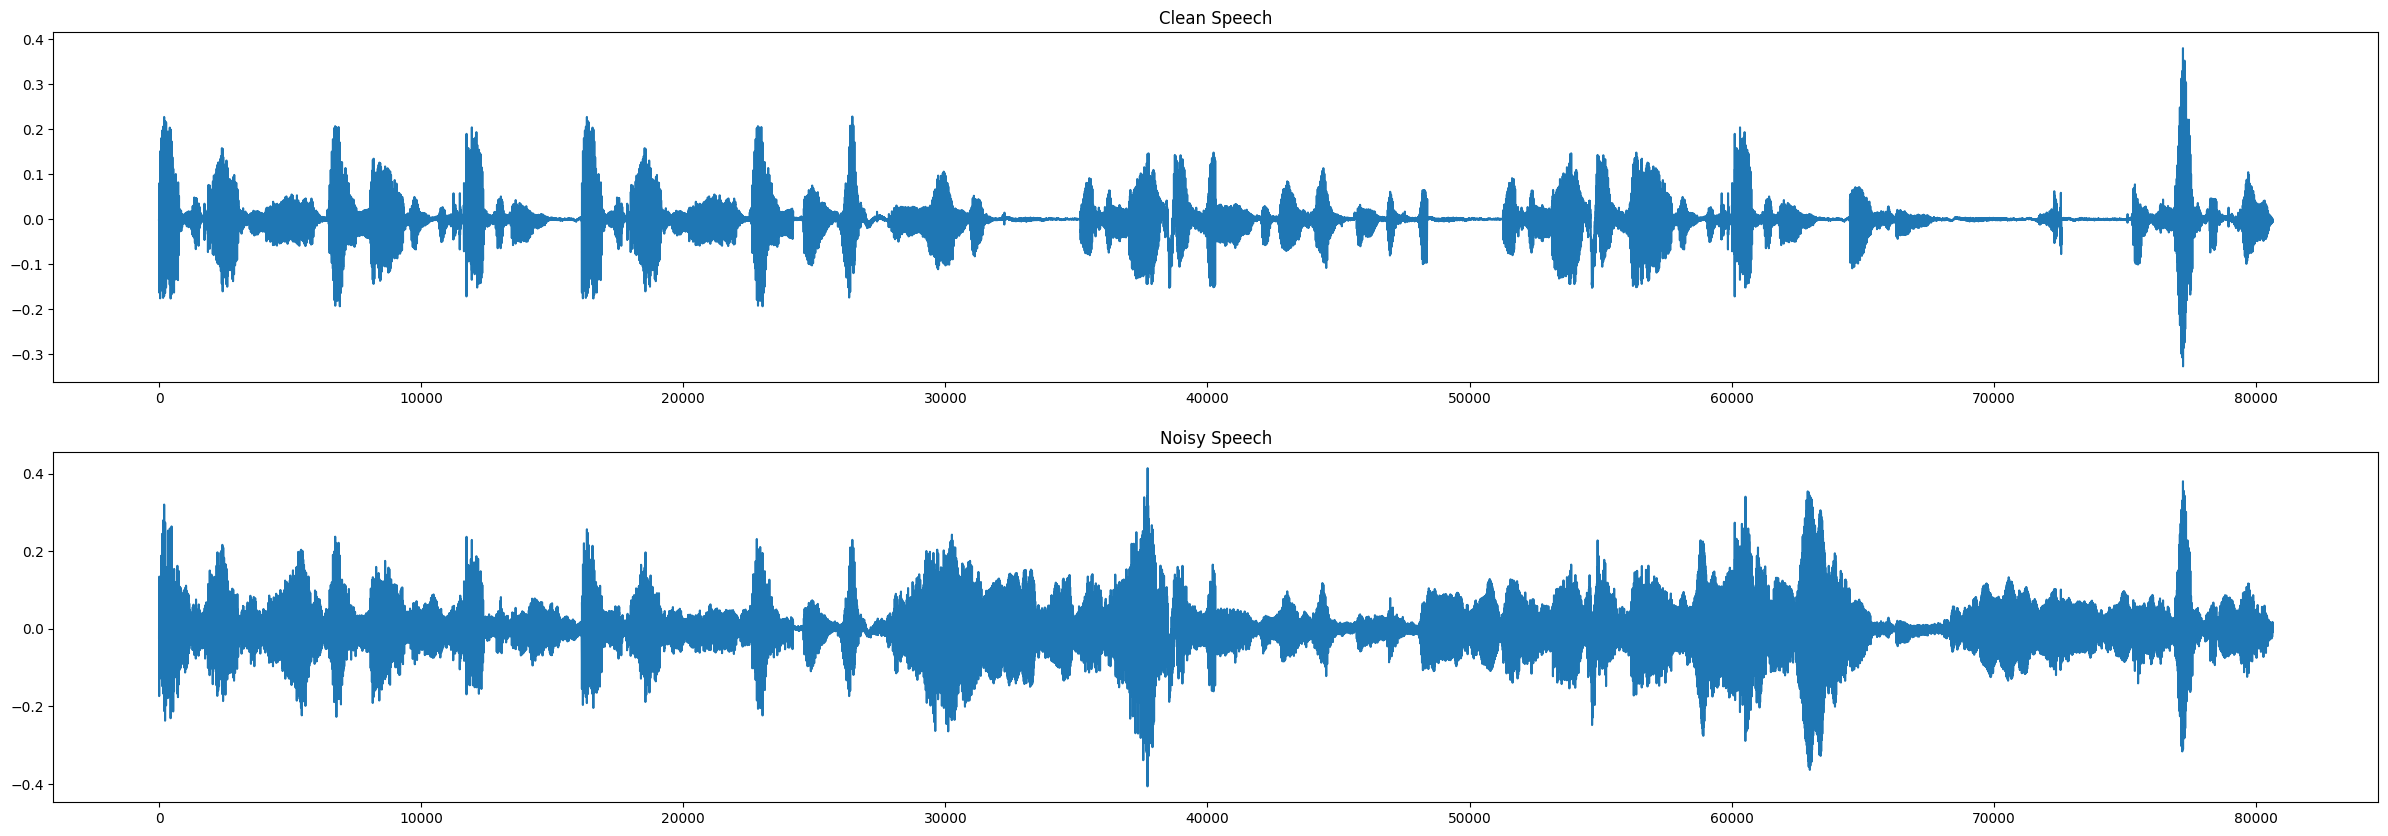

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.title("Clean Speech")
plt.plot(samples_clean)

plt.subplot(212)
plt.title("Noisy Speech")
plt.plot(samples_noisy_clean)

plt.show()

In [17]:
import soundfile as sf
clean_nb_samples = prod_voice.shape[0]
clean_long = prod_voice.reshape(1, 10 * frame_length)*10
sf.write("clean_long.wav", clean_long[0,:], 8000, 'PCM_24')

In [18]:
from IPython.display import Audio
Audio('clean_long.wav')

In [19]:
noise_nb_samples = prod_noisy_voice.shape[0]
noise_long = prod_noisy_voice.reshape(1, 10 * frame_length)*10
sf.write("noise_long.wav", noise_long[0,:], 8000, 'PCM_24')

In [20]:
from IPython.display import Audio
Audio('noise_long.wav')

# Simple model for de-noising.

In [21]:
def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):

    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase

In [22]:
def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    nb_audio = numpy_audio.shape[0]
    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase

In [23]:
def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, hop_length_frame, min_duration):

    list_sound_array = []

    count = 0
    for file in list_audio_files:
      try:
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=sample_rate)
        total_duration = librosa.get_duration(y=y, sr=sr)
      except ZeroDivisionError:
        count += 1

      if (total_duration >= min_duration):
          list_sound_array.append(audio_to_audio_frame_stack(
              y, frame_length, hop_length_frame))
      else:
          print(
              f"The following file {os.path.join(audio_dir,file)} is below the min duration")

    return np.vstack(list_sound_array)

In [24]:
def create_data(noise_dir, voice_dir,path_save_spectrogram, sample_rate,
min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft):


    list_noise_files = os.listdir(noise_dir)
    list_voice_files = os.listdir(voice_dir)

    def remove_ds_store(lst):
        if '.DS_Store' in lst:
            lst.remove('.DS_Store')

        return lst

    list_noise_files = remove_ds_store(list_noise_files)
    list_voice_files = remove_ds_store(list_voice_files)

    nb_voice_files = len(list_voice_files)
    nb_noise_files = len(list_noise_files)

    noise = audio_files_to_numpy(noise_dir, list_noise_files, sample_rate,
                                     frame_length, hop_length_frame_noise, min_duration)

    voice = audio_files_to_numpy(voice_dir, list_voice_files,
                                     sample_rate, frame_length, hop_length_frame, min_duration)

    prod_voice, prod_noise, prod_noisy_voice = blend_noise_randomly(
            voice, noise, nb_samples, frame_length)


    dim_square_spec = int(n_fft / 2) + 1

    m_amp_db_voice,  m_pha_voice = numpy_audio_to_matrix_spectrogram(
            prod_voice, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noise,  m_pha_noise = numpy_audio_to_matrix_spectrogram(
            prod_noise, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noisy_voice,  m_pha_noisy_voice = numpy_audio_to_matrix_spectrogram(
            prod_noisy_voice, dim_square_spec, n_fft, hop_length_fft)

    np.save(path_save_spectrogram + 'voice_amp_db', m_amp_db_voice)
    np.save(path_save_spectrogram + 'noise_amp_db', m_amp_db_noise)
    np.save(path_save_spectrogram + 'noisy_voice_amp_db', m_amp_db_noisy_voice)

In [25]:
!mkdir spectogram


noise_dir="/kaggle/working/noise/"
voice_dir="/kaggle/working/clean_speech/"
path_save_spectrogram="/kaggle/working/spectogram/"
sample_rate=8000
min_duration=1.0
frame_length=8064
hop_length_frame=8064
hop_length_frame_noise=5000
nb_samples=5000
n_fft=255
hop_length_fft=63

create_data(noise_dir=noise_dir,voice_dir=voice_dir,
            path_save_spectrogram=path_save_spectrogram,
            sample_rate=sample_rate,
            min_duration=min_duration,
            frame_length=frame_length,
            hop_length_frame=hop_length_frame,
            hop_length_frame_noise=hop_length_frame_noise,
            nb_samples=nb_samples,
            n_fft=n_fft,
            hop_length_fft=hop_length_fft)

noisy_voice_amp_db = np.load('/kaggle/working/spectogram/noisy_voice_amp_db.npy')
print(np.shape(noisy_voice_amp_db))


(5000, 128, 128)


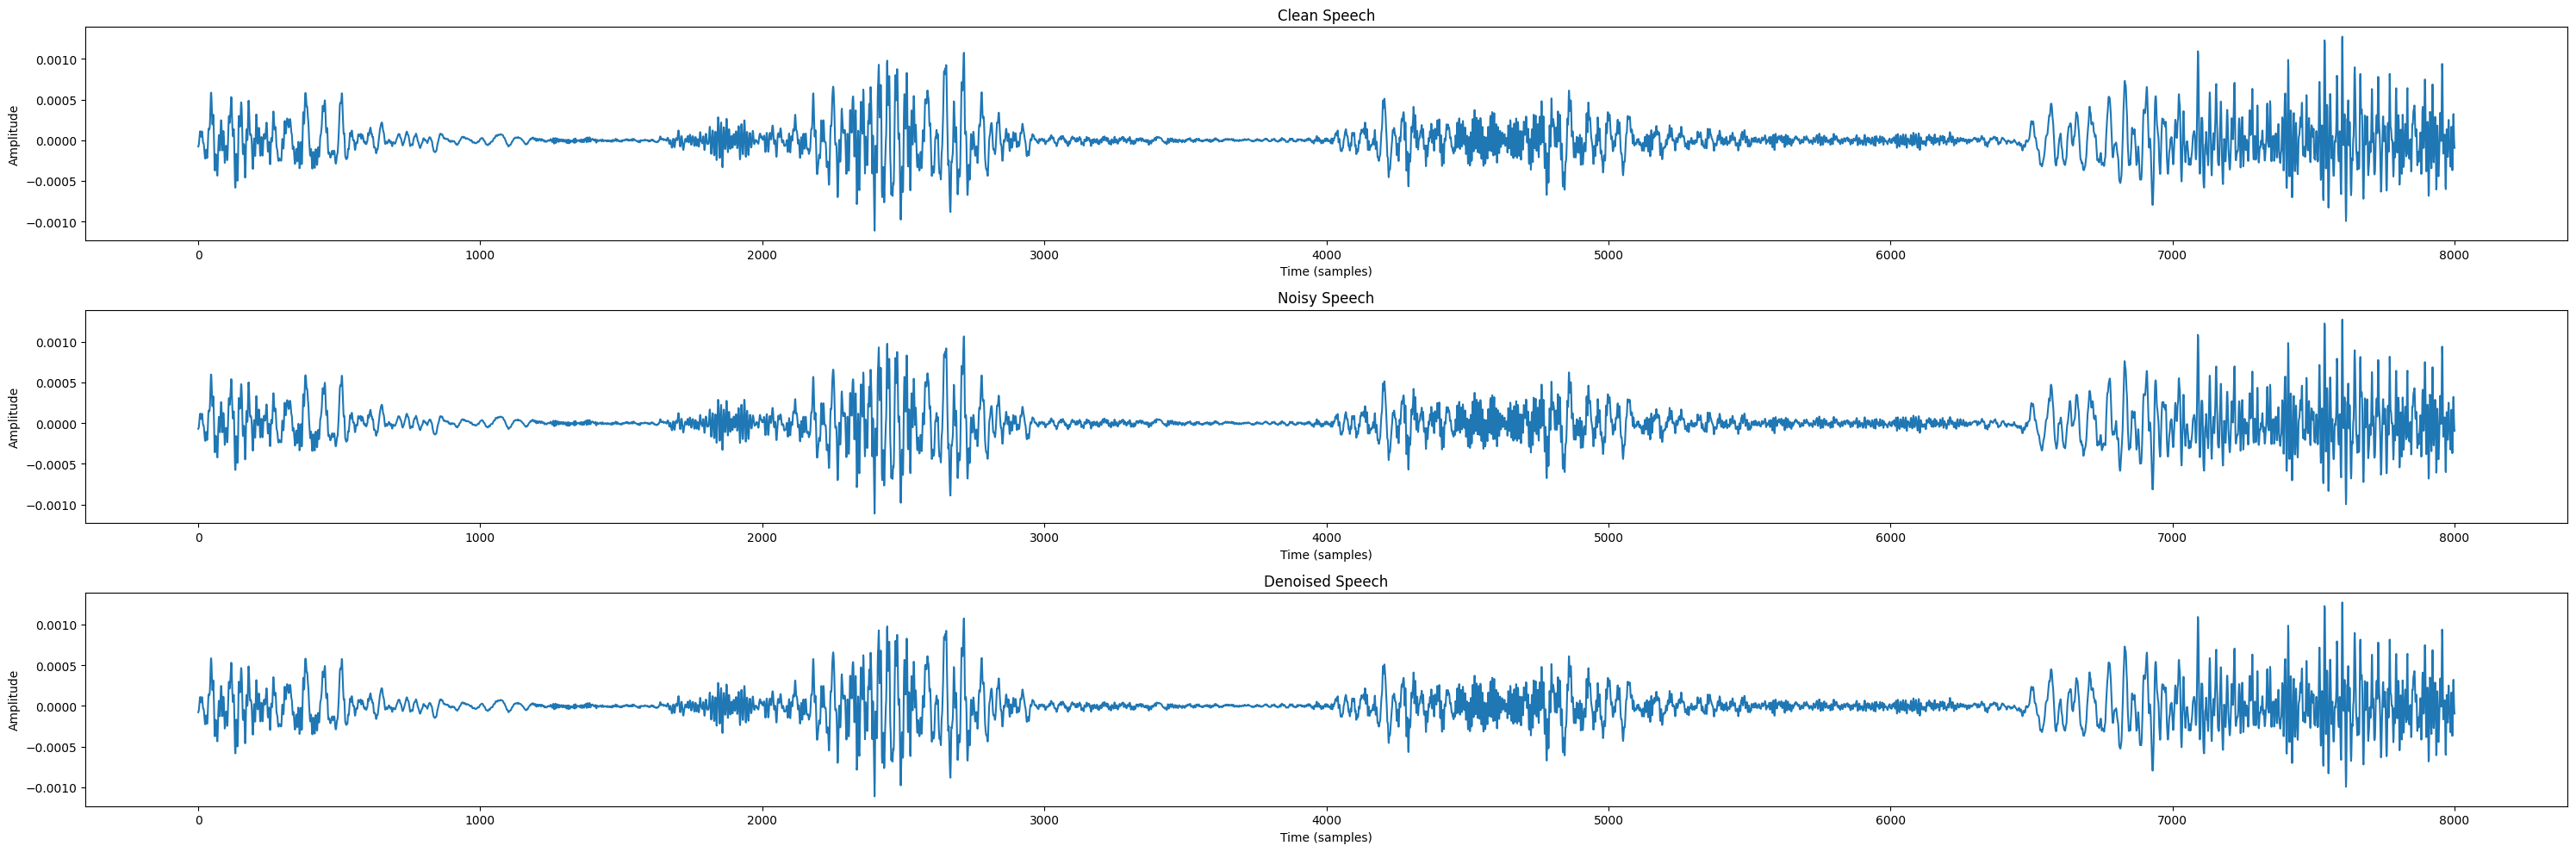

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import Audio

def load_spectrograms(path_save_spectrogram):
    noisy_spectrogram = np.load(os.path.join(path_save_spectrogram, 'noisy_voice_amp_db.npy'))
    clean_spectrogram = np.load(os.path.join(path_save_spectrogram, 'voice_amp_db.npy'))
    return noisy_spectrogram, clean_spectrogram

def spectrogram_to_waveform(spectrogram, n_fft, hop_length_fft):
    amplitude = librosa.db_to_amplitude(spectrogram)
    if amplitude.shape[0] < n_fft:
        amplitude = np.pad(amplitude, ((0, n_fft - amplitude.shape[0]), (0, 0)), mode='constant')
    waveform = librosa.istft(amplitude, hop_length=hop_length_fft, win_length=n_fft)
    return waveform

def plot_waveforms(samples_clean, samples_noisy, samples_denoised, sr=8000):
    plt.figure(figsize=(30, 10))

    plt.subplot(311)
    plt.title("Clean Speech")
    plt.plot(samples_clean)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.subplot(312)
    plt.title("Noisy Speech")
    plt.plot(samples_noisy)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.subplot(313)
    plt.title("Denoised Speech")
    plt.plot(samples_denoised)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

path_save_spectrogram = "/kaggle/working/spectogram/"
n_fft = 255
hop_length_fft = 63
sample_rate = 8000

noisy_spectrogram, clean_spectrogram = load_spectrograms(path_save_spectrogram)

denoised_spectrogram = clean_spectrogram

noisy_waveform = spectrogram_to_waveform(noisy_spectrogram[0], n_fft, hop_length_fft)
clean_waveform = spectrogram_to_waveform(clean_spectrogram[0], n_fft, hop_length_fft)
denoised_waveform = spectrogram_to_waveform(denoised_spectrogram[0], n_fft, hop_length_fft)

sf.write("noisy.wav", noisy_waveform, sample_rate)
sf.write("clean.wav", clean_waveform, sample_rate)
sf.write("denoised.wav", denoised_waveform, sample_rate)

plot_waveforms(clean_waveform, noisy_waveform, denoised_waveform, sr=sample_rate)

display(Audio("noisy.wav"))
display(Audio("clean.wav"))
display(Audio("denoised.wav"))


In [27]:
noisy_voice = np.load("/kaggle/working/spectogram/noisy_voice_amp_db.npy")
voice = np.load("/kaggle/working/spectogram/voice_amp_db.npy")
noise = noisy_voice-voice

In [28]:
print(noisy_voice.shape)
print(noise.shape)

(5000, 128, 128)
(5000, 128, 128)


In [29]:
def scaled_in(matrix_spec):
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec

def scaled_ou(matrix_spec):
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec
from scipy import stats


X_in = np.load(path_save_spectrogram +'noisy_voice_amp_db'+".npy")
X_ou = np.load(path_save_spectrogram +'voice_amp_db'+".npy")
X_ou = X_in - X_ou

print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))

X_in = scaled_in(X_in)
X_ou = scaled_ou(X_ou)

print(X_in.shape)
print(X_ou.shape)

print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))


X_in = X_in[:,:,:]
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
X_ou = X_ou[:,:,:]
X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

DescribeResult(nobs=81920000, minmax=(array([-80.]), array([7.10542736e-15])), mean=array([-44.75320812]), variance=array([279.67978939]), skewness=array([-0.14396831]), kurtosis=array([-0.41488846]))
DescribeResult(nobs=81920000, minmax=(array([-66.17342874]), array([80.])), mean=array([7.46336014]), variance=array([179.13881519]), skewness=array([1.36543251]), kurtosis=array([1.64439077]))
(5000, 128, 128)
(5000, 128, 128)
DescribeResult(nobs=81920000, minmax=(array([-0.68]), array([0.92])), mean=array([0.02493584]), variance=array([0.11187192]), skewness=array([-0.14396831]), kurtosis=array([-0.41488846]))
DescribeResult(nobs=81920000, minmax=(array([-0.88016377]), array([0.90243902])), mean=array([0.01784586]), variance=array([0.0266417]), skewness=array([1.36543251]), kurtosis=array([1.64439077]))
(4000, 128, 128, 1)
(1000, 128, 128, 1)
(4000, 128, 128, 1)
(1000, 128, 128, 1)


In [30]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
def unet(input_size=(128, 128, 1)):
    size_filter_in = 16
    kernel_init = 'he_normal'
    activation_layer = LeakyReLU()

    regularizer = l1_l2(l1=1e-5, l2=1e-4)  

    inputs = Input(input_size)
    conv_args = dict(padding='same', 
                     kernel_initializer=kernel_init, 
                     activation=activation_layer, 
                     kernel_regularizer=regularizer)

    conv1 = Conv2D(size_filter_in, 3, **conv_args)(inputs)
    conv1 = Conv2D(size_filter_in, 3, **conv_args)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(size_filter_in*2, 3, **conv_args)(pool1)
    conv2 = Conv2D(size_filter_in*2, 3, **conv_args)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(size_filter_in*4, 3, **conv_args)(pool2)
    conv3 = Conv2D(size_filter_in*4, 3, **conv_args)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(size_filter_in*8, 3, **conv_args)(pool3)
    conv4 = Conv2D(size_filter_in*8, 3, **conv_args)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, **conv_args)(pool4)
    conv5 = Conv2D(size_filter_in*16, 3, **conv_args)(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, **conv_args)(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(size_filter_in*8, 3, **conv_args)(merge6)
    conv6 = Conv2D(size_filter_in*8, 3, **conv_args)(conv6)

    up7 = Conv2D(size_filter_in*4, 2, **conv_args)(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(size_filter_in*4, 3, **conv_args)(merge7)
    conv7 = Conv2D(size_filter_in*4, 3, **conv_args)(conv7)

    up8 = Conv2D(size_filter_in*2, 2, **conv_args)(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(size_filter_in*2, 3, **conv_args)(merge8)
    conv8 = Conv2D(size_filter_in*2, 3, **conv_args)(conv8)

    up9 = Conv2D(size_filter_in, 2, **conv_args)(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(size_filter_in, 3, **conv_args)(merge9)
    conv9 = Conv2D(size_filter_in, 3, **conv_args)(conv9)

    conv10 = Conv2D(1, 1, activation='tanh')(conv9)
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = Adam(learning_rate=lr_schedule)
    model = Model(inputs, conv10)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    return model


In [31]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from scipy import stats
import matplotlib.pyplot as plt

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def plot_waveforms(samples_clean, samples_noisy, samples_denoised, sr=8000):
    plt.figure(figsize=(30, 10))

    plt.subplot(311)
    plt.title("Clean Speech")
    plt.plot(samples_clean)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.subplot(312)
    plt.title("Noisy Speech")
    plt.plot(samples_noisy)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.subplot(313)
    plt.title("Denoised Speech")
    plt.plot(samples_denoised)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

def plot_spectrograms(generator_nn, X_test, y_test, num_samples=3):
    indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
    noisy_samples = X_test[indices]
    denoised_samples = generator_nn.predict(noisy_samples)

    plt.figure(figsize=(15, 3*num_samples))
    for i in range(num_samples):
        noisy_spec = librosa.amplitude_to_db(np.abs(librosa.stft(noisy_samples[i].squeeze())), ref=np.max)
        denoised_spec = librosa.amplitude_to_db(np.abs(librosa.stft(denoised_samples[i].squeeze())), ref=np.max)

        plt.subplot(num_samples, 2, 2*i + 1)
        librosa.display.specshow(noisy_spec.squeeze(), sr=44100, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Noisy Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency')

        plt.subplot(num_samples, 2, 2*i + 2)
        librosa.display.specshow(denoised_spec.squeeze(), sr=44100, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Denoised Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [32]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def training_unet(path_save_spectrogram, weights_path, epochs, batch_size):
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPUs available: {len(gpus)}")

    strategy = tf.distribute.MirroredStrategy()

    print(f"Number of devices: {strategy.num_replicas_in_sync}")

    X_in = np.load(path_save_spectrogram + 'noisy_voice_amp_db.npy')
    X_ou = np.load(path_save_spectrogram + 'voice_amp_db.npy')
    X_ou = X_in - X_ou

    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    X_in = X_in[:, :, :]
    X_in = X_in.reshape(X_in.shape[0], X_in.shape[1], X_in.shape[2], 1)
    X_ou = X_ou[:, :, :]
    X_ou = X_ou.reshape(X_ou.shape[0], X_ou.shape[1], X_ou.shape[2], 1)

    X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.30, random_state=42)

    with strategy.scope():
        generator_nn = unet()

        checkpoint = ModelCheckpoint(
            weights_path + '/model_unet_best.keras', 
            verbose=1, 
            monitor='val_loss',
            save_best_only=True, 
            mode='auto'
        )

        generator_nn.compile(
            optimizer='adam', 
            loss='mean_squared_error', 
            metrics=[psnr, ssim, 'mae']
        )

    history = generator_nn.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=batch_size * strategy.num_replicas_in_sync,
        shuffle=True,
        callbacks=[checkpoint], 
        verbose=1, 
        validation_data=(X_test, y_test)
    )

    plot_training_metrics(history)

def plot_training_metrics(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    psnr_values = history.history['psnr']
    val_psnr_values = history.history['val_psnr']
    ssim_values = history.history['ssim']
    val_ssim_values = history.history['val_ssim']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 4, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs, mae, 'r', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(epochs, psnr_values, 'r', label='Training PSNR')
    plt.plot(epochs, val_psnr_values, 'b', label='Validation PSNR')
    plt.title('Training and validation PSNR')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs, ssim_values, 'r', label='Training SSIM')
    plt.plot(epochs, val_ssim_values, 'b', label='Validation SSIM')
    plt.title('Training and validation SSIM')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [33]:
import time

mkdir: cannot create directory ‘weights’: File exists
GPUs available: 2
Number of devices: 2
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.1187 - mae: 0.2467 - psnr: 12.2942 - ssim: 0.0179
Epoch 1: val_loss improved from inf to 0.02541, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 514ms/step - loss: 0.1166 - mae: 0.2439 - psnr: 12.3861 - ssim: 0.0187 - val_loss: 0.0254 - val_mae: 0.1211 - val_psnr: 16.8111 - val_ssim: 0.0752
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0234 - mae: 0.1146 - psnr: 17.4670 - ssim: 0.1007
Epoch 2: val_loss improved from 0.02541 to 0.02246, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - loss: 0.0234 - mae: 0.1145 - psnr: 17.4779 - ssim: 0.1010 - val_loss: 0.0225 - val_mae: 0.1165 - val_psnr: 17.3864 - val_ssim: 0.0313
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0209 - mae: 0.1073 - psnr: 18.1305 - ssim: 0.1394
Epoch 3: val_loss

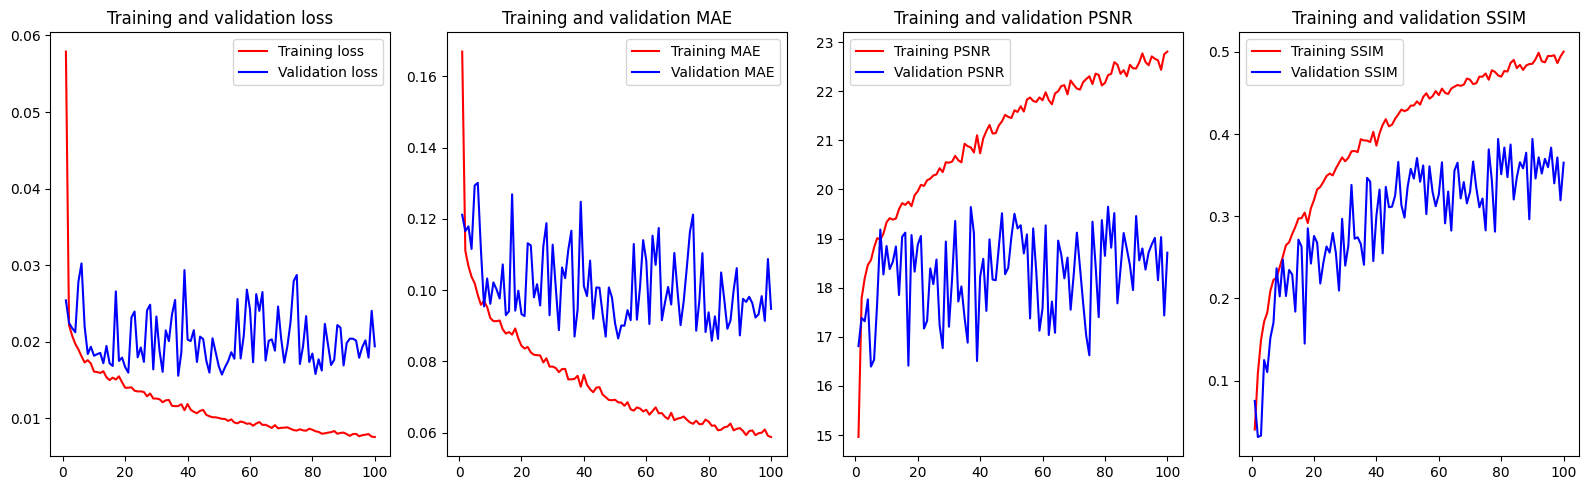

Time taken for denoising: 846.5384752750397 seconds


In [39]:
!mkdir weights

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (epochs=100, batch_size=64, l1=1e-5, l2=1e-4)

mkdir: cannot create directory ‘weights’: File exists
GPUs available: 2
Number of devices: 2
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 1.1706 - mae: 0.3290 - psnr: 10.4531 - ssim: 0.0023
Epoch 1: val_loss improved from inf to 0.96718, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - loss: 1.1667 - mae: 0.3250 - psnr: 10.5698 - ssim: 0.0025 - val_loss: 0.9672 - val_mae: 0.1444 - val_psnr: 15.7079 - val_ssim: 0.0183
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.9367 - mae: 0.1182 - psnr: 17.1843 - ssim: 0.0634
Epoch 2: val_loss improved from 0.96718 to 0.88181, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - loss: 0.9361 - mae: 0.1181 - psnr: 17.1937 - ssim: 0.0638 - val_loss: 0.8818 - val_mae: 0.1221 - val_psnr: 17.0740 - val_ssim: 0.0417
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.8607 - mae: 0.1104 - psnr: 17.8728 - ssim: 0.1059
Epoch 3: val_loss

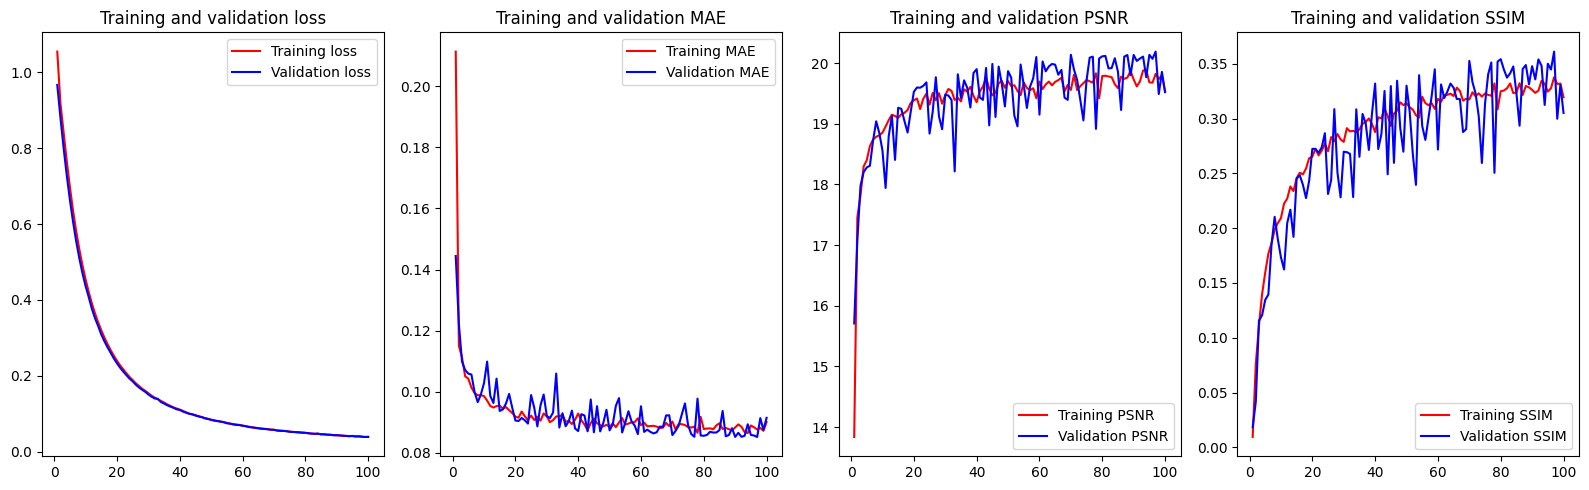

Time taken for denoising: 857.1448826789856 seconds


In [44]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (5000 data, epochs=100, batch_size=64, l1=1e-4, l2=1e-3)

GPUs available: 2
Number of devices: 2
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 9.3473 - mae: 0.3399 - psnr: 10.0448 - ssim: 0.0178
Epoch 1: val_loss improved from inf to 7.00620, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - loss: 9.3215 - mae: 0.3355 - psnr: 10.1611 - ssim: 0.0180 - val_loss: 7.0062 - val_mae: 0.1255 - val_psnr: 16.6343 - val_ssim: 0.0134
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 6.3724 - mae: 0.1208 - psnr: 16.9531 - ssim: 0.0494
Epoch 2: val_loss improved from 7.00620 to 4.63660, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - loss: 6.3530 - mae: 0.1207 - psnr: 16.9608 - ssim: 0.0500 - val_loss: 4.6366 - val_mae: 0.1122 - val_psnr: 17.6852 - val_ssim: 0.0894
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 4.2287 - mae: 0.1119 - psnr: 17.7427 - ssim: 0.0951
Epoch 3: val_loss improved from 4.63660 to 3.15401, saving model to ./w

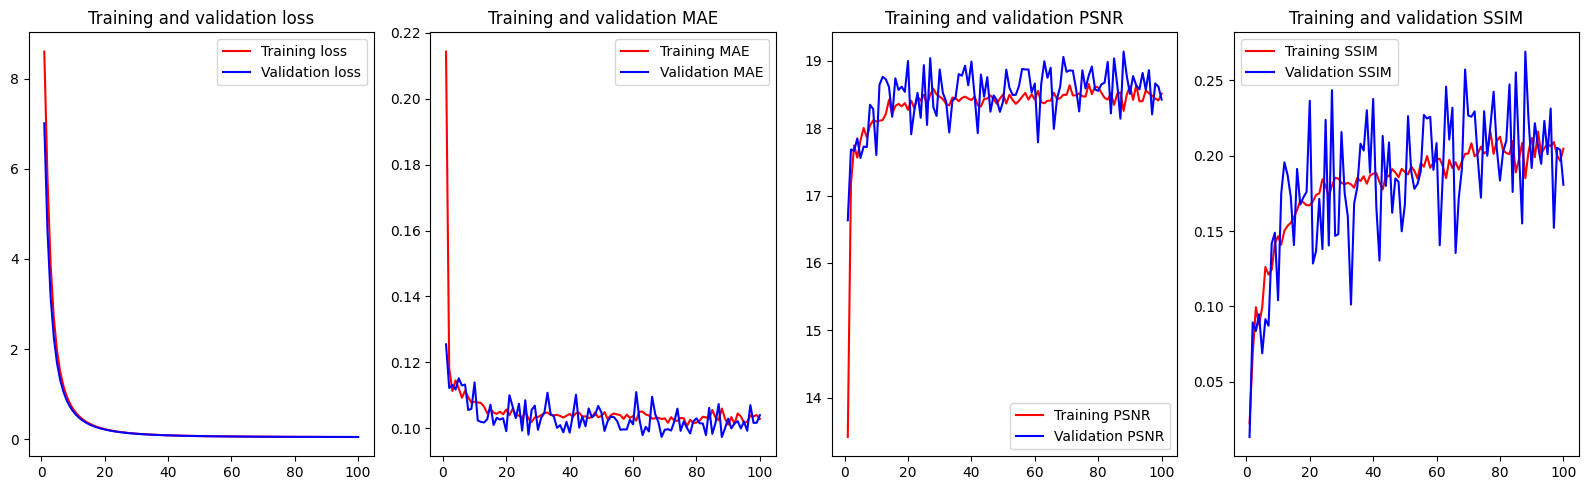

Time taken for denoising: 852.5365478992462 seconds


In [46]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (5000 data, epochs=100, batch_size=32, l1=1e-3, l2=1e-2)

GPUs available: 2
Number of devices: 2
Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 72.9297 - mae: 0.2639 - psnr: 13.0335 - ssim: 0.0038
Epoch 1: val_loss improved from inf to 21.67728, saving model to ./weights/model_unet_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - loss: 72.5707 - mae: 0.2621 - psnr: 13.0805 - ssim: 0.0038 - val_loss: 21.6773 - val_mae: 0.1216 - val_psnr: 17.1471 - val_ssim: -0.0117
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 15.9871 - mae: 0.1210 - psnr: 17.2028 - ssim: -0.0123
Epoch 2: val_loss improved from 21.67728 to 6.15619, saving model to ./weights/model_unet_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 15.9156 - mae: 0.1210 - psnr: 17.2025 - ssim: -0.0123 - val_loss: 6.1562 - val_mae: 0.1219 - val_psnr: 17.1853 - val_ssim: -0.0301
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 5.0421 - mae: 0.1225 - psnr: 17.1717 - ssim: -0.0219
Epoch 3: val_loss improved from 6.15619 to 2.77979, saving 

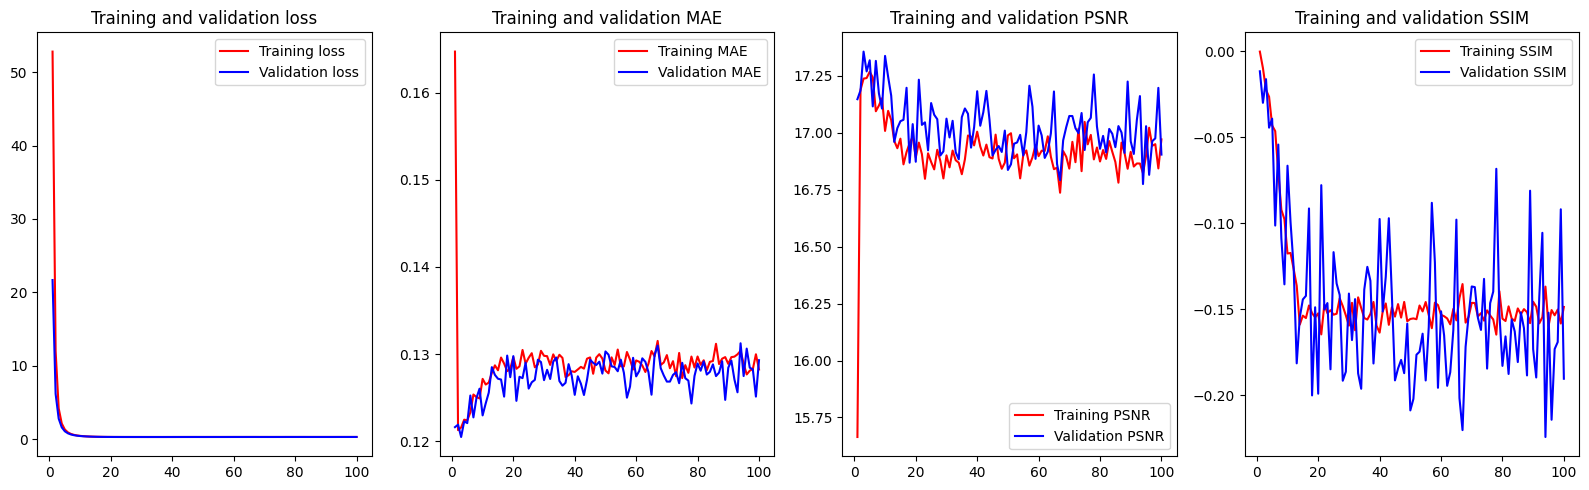

Time taken for denoising: 854.705798625946 seconds


In [48]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=32)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (5000 data, epochs=100, batch_size=64, l1=1e-6, l2=1e-5)

GPUs available: 2
Number of devices: 2
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.2145 - mae: 0.2280 - psnr: 13.3223 - ssim: 0.0277
Epoch 1: val_loss improved from inf to 0.12366, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - loss: 0.2124 - mae: 0.2257 - psnr: 13.4007 - ssim: 0.0280 - val_loss: 0.1237 - val_mae: 0.1269 - val_psnr: 16.5452 - val_ssim: 0.0425
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.1201 - mae: 0.1165 - psnr: 17.4329 - ssim: 0.0748
Epoch 2: val_loss did not improve from 0.12366
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - loss: 0.1201 - mae: 0.1165 - psnr: 17.4371 - ssim: 0.0753 - val_loss: 0.1254 - val_mae: 0.1473 - val_psnr: 15.4298 - val_ssim: -0.0330
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.1154 - mae: 0.1078 - psnr: 18.1565 - ssim: 0.1354
Epoch 3: val_loss improved from 0.12366 to 0.12038, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━

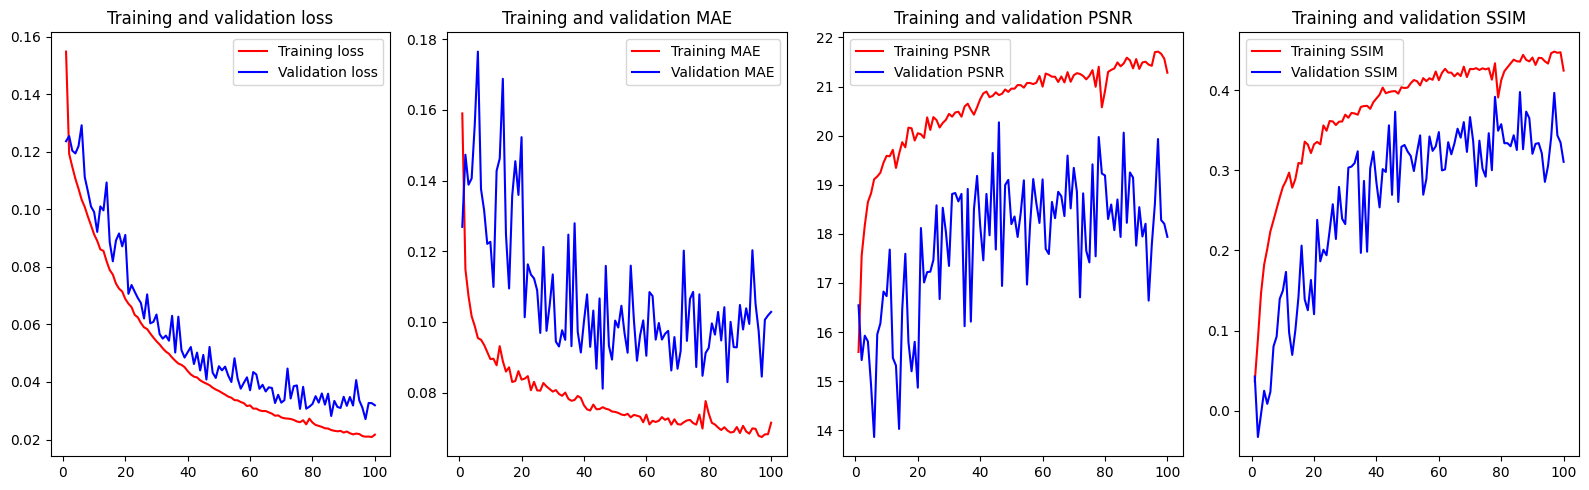

Time taken for denoising: 837.7568469047546 seconds


In [51]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (5000 data, epochs=100, batch_size=256, l1=1e-6, l2=1e-5)

GPUs available: 2
Number of devices: 2
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4184 - mae: 0.4477 - psnr: 6.9583 - ssim: 0.0116
Epoch 1: val_loss improved from inf to 0.13725, saving model to ./weights/model_unet_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - loss: 0.4083 - mae: 0.4382 - psnr: 7.1781 - ssim: 0.0115 - val_loss: 0.1372 - val_mae: 0.1614 - val_psnr: 14.1865 - val_ssim: -0.0410
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - loss: 0.1375 - mae: 0.1584 - psnr: 14.5071 - ssim: -0.0091
Epoch 2: val_loss improved from 0.13725 to 0.13363, saving model to ./weights/model_unet_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.1372 - mae: 0.1575 - psnr: 14.5658 - ssim: -0.0074 - val_loss: 0.1336 - val_mae: 0.1368 - val_psnr: 15.8225 - val_ssim: 0.0734
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - loss: 0.1268 - mae: 0.1291 - psnr: 16.2132 - ssim: 0.0419
Epoch 3: val_loss improved from 0.13363 to 0.12384, saving model to ./weights/model_unet_

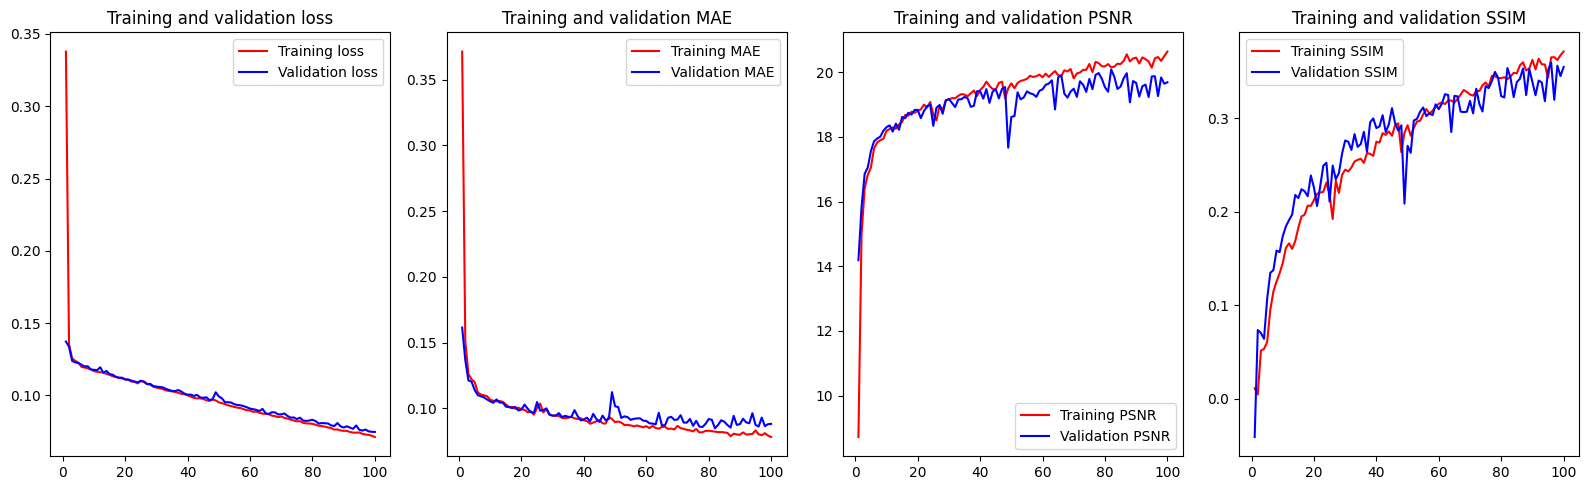

Time taken for denoising: 925.773421049118 seconds


In [52]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=256)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# Time change(5000 data, epochs=25, batch_size=32/64)

GPUs available: 2
Number of devices: 2
Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 1.1459 - mae: 0.2941 - psnr: 12.0904 - ssim: 0.0102
Epoch 1: val_loss improved from inf to 0.90989, saving model to ./weights/model_unet_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - loss: 1.1435 - mae: 0.2920 - psnr: 12.1521 - ssim: 0.0105 - val_loss: 0.9099 - val_mae: 0.1560 - val_psnr: 14.9487 - val_ssim: -0.0713
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.8641 - mae: 0.1100 - psnr: 17.9701 - ssim: 0.0890
Epoch 2: val_loss improved from 0.90989 to 0.76426, saving model to ./weights/model_unet_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 0.8636 - mae: 0.1100 - psnr: 17.9714 - ssim: 0.0892 - val_loss: 0.7643 - val_mae: 0.1212 - val_psnr: 17.1857 - val_ssim: 0.0592
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.7305 - mae: 0.1068 - psnr: 18.2812 - ssim: 0.1296
Epoch 3: val_loss improved from 0.76426 to 0.64095, saving model to ./wei

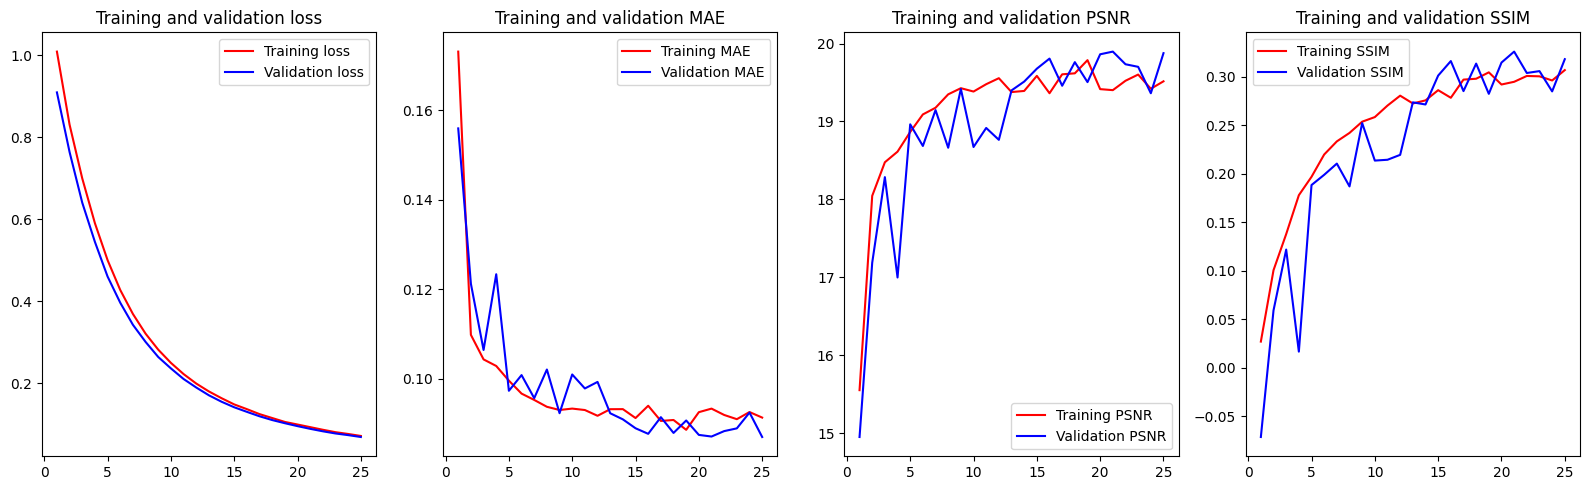

Time taken for denoising: 236.96598291397095 seconds


In [39]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  25 ,batch_size=32)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

GPUs available: 2
Number of devices: 2
Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 1.1979 - mae: 0.3375 - psnr: 11.0092 - ssim: -0.0027
Epoch 1: val_loss improved from inf to 0.93602, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 407ms/step - loss: 1.1925 - mae: 0.3326 - psnr: 11.1310 - ssim: -0.0019 - val_loss: 0.9360 - val_mae: 0.1269 - val_psnr: 16.4739 - val_ssim: 0.0104
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.9109 - mae: 0.1151 - psnr: 17.3639 - ssim: 0.0779
Epoch 2: val_loss improved from 0.93602 to 0.83668, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - loss: 0.9101 - mae: 0.1150 - psnr: 17.3748 - ssim: 0.0784 - val_loss: 0.8367 - val_mae: 0.1114 - val_psnr: 17.6808 - val_ssim: 0.0902
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.8126 - mae: 0.1086 - psnr: 17.9910 - ssim: 0.1225
Epoch 3: val_loss improved from 0.83668 to 0.74268, saving model to ./we

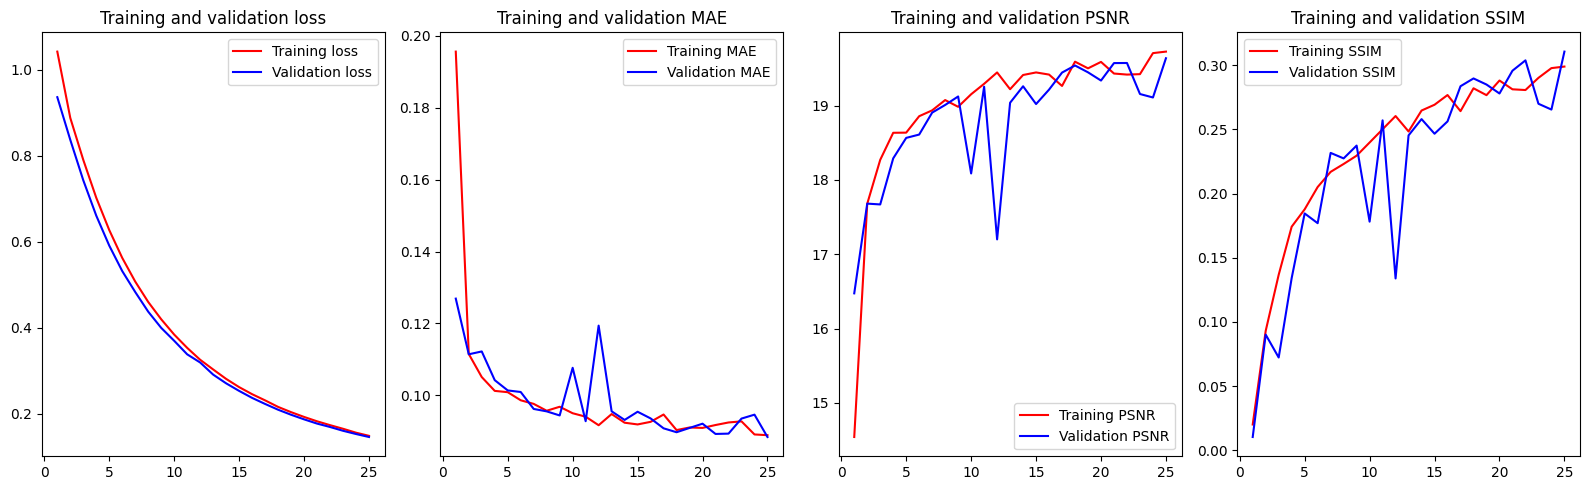

Time taken for denoising: 231.12019419670105 seconds


In [40]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  25 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# Time change(5000 data, epochs=50, batch_size=32/64)

GPUs available: 2
Number of devices: 2
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 1.0883 - mae: 0.2504 - psnr: 12.3446 - ssim: 0.0071
Epoch 1: val_loss improved from inf to 0.93072, saving model to ./weights/model_unet_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - loss: 1.0868 - mae: 0.2490 - psnr: 12.3920 - ssim: 0.0073 - val_loss: 0.9307 - val_mae: 0.1721 - val_psnr: 13.9716 - val_ssim: -0.0323
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.8826 - mae: 0.1163 - psnr: 17.3493 - ssim: 0.0644
Epoch 2: val_loss improved from 0.93072 to 0.79627, saving model to ./weights/model_unet_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.8820 - mae: 0.1162 - psnr: 17.3543 - ssim: 0.0646 - val_loss: 0.7963 - val_mae: 0.1459 - val_psnr: 15.5084 - val_ssim: -0.0384
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.7582 - mae: 0.1083 - psnr: 18.0298 - ssim: 0.1110
Epoch 3: val_loss improved from 0.79627 to 0.68353, saving model to ./we

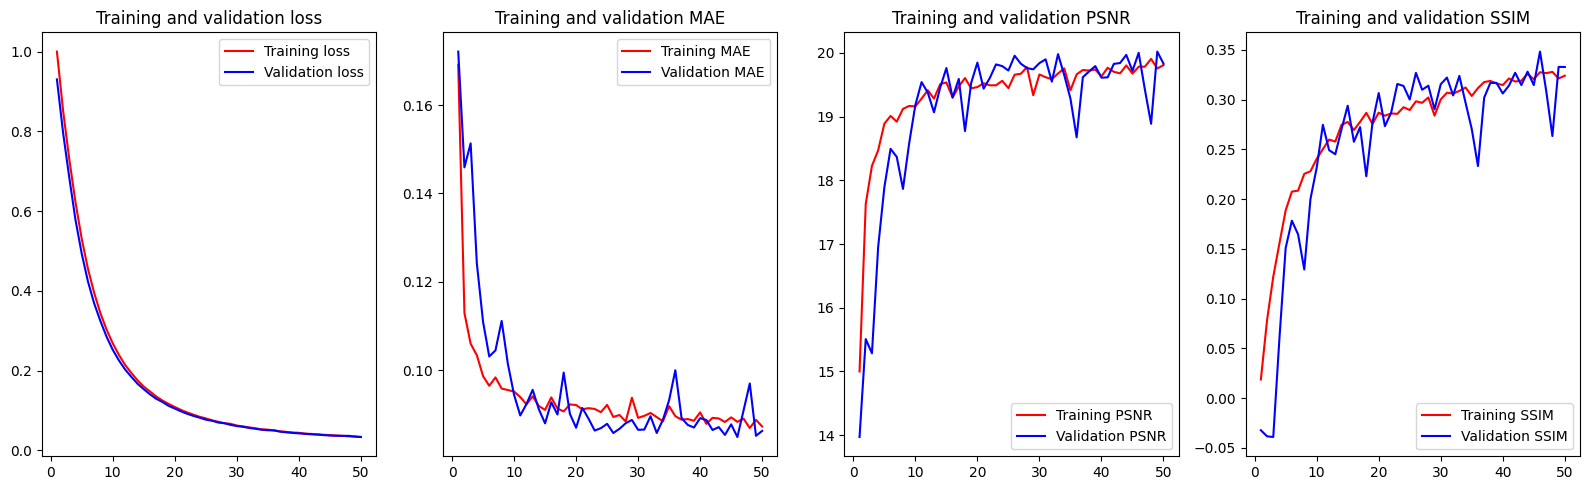

Time taken for denoising: 451.7938425540924 seconds


In [41]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  50 ,batch_size=32)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

GPUs available: 2
Number of devices: 2
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 1.4041 - mae: 0.5394 - psnr: 6.0596 - ssim: -0.0035
Epoch 1: val_loss improved from inf to 1.06544, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - loss: 1.3981 - mae: 0.5338 - psnr: 6.1720 - ssim: -0.0030 - val_loss: 1.0654 - val_mae: 0.2440 - val_psnr: 11.7742 - val_ssim: 0.0885
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.9885 - mae: 0.1344 - psnr: 16.3055 - ssim: -0.0037
Epoch 2: val_loss improved from 1.06544 to 0.98044, saving model to ./weights/model_unet_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 301ms/step - loss: 0.9882 - mae: 0.1341 - psnr: 16.3216 - ssim: -0.0036 - val_loss: 0.9804 - val_mae: 0.1593 - val_psnr: 14.4475 - val_ssim: -0.0309
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.9599 - mae: 0.1180 - psnr: 17.2701 - ssim: 0.0381
Epoch 3: val_loss improved from 0.98044 to 0.95380, saving model to ./w

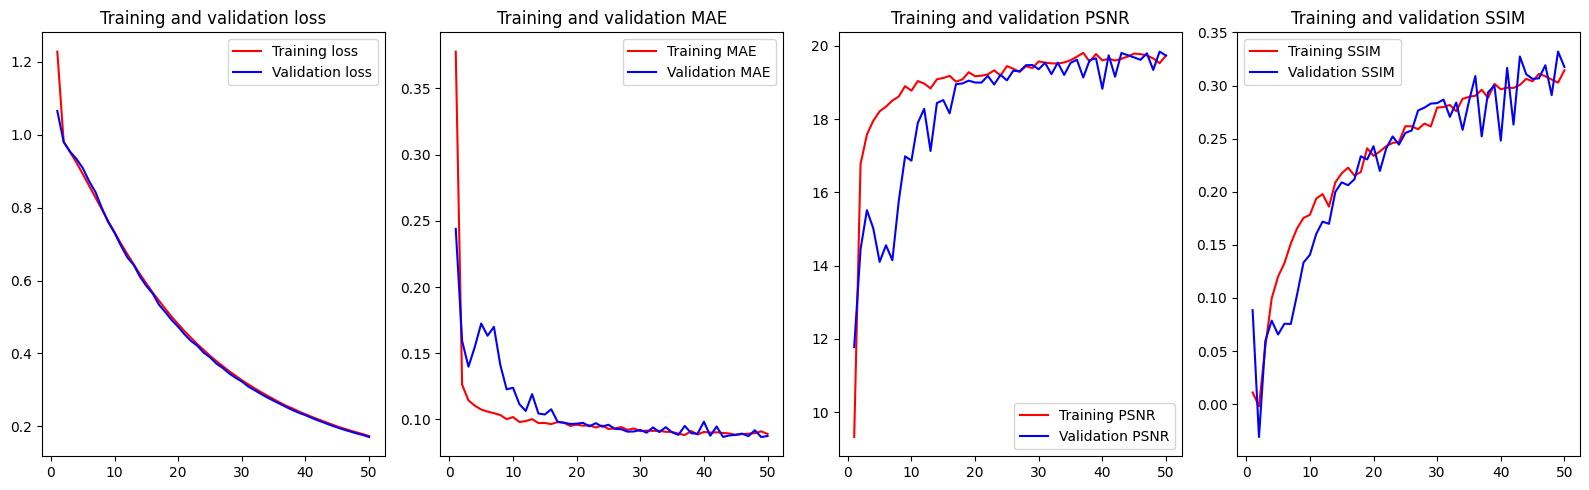

Time taken for denoising: 446.55057859420776 seconds


In [42]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  50 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# L1/L2 Regularization (8000 data, epochs=100, batch_size=64, l1=1e-5, l2=1e-4)

GPUs available: 2
Number of devices: 2
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 1.2634 - mae: 0.3894 - psnr: 10.2433 - ssim: 7.9232e-04
Epoch 1: val_loss improved from inf to 0.97079, saving model to ./weights/model_unet_best.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 449ms/step - loss: 1.2592 - mae: 0.3854 - psnr: 10.3371 - ssim: 9.3252e-04 - val_loss: 0.9708 - val_mae: 0.1479 - val_psnr: 15.0021 - val_ssim: 0.0421
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.9421 - mae: 0.1149 - psnr: 17.5668 - ssim: 0.0654
Epoch 2: val_loss improved from 0.97079 to 0.89159, saving model to ./weights/model_unet_best.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - loss: 0.9417 - mae: 0.1149 - psnr: 17.5718 - ssim: 0.0657 - val_loss: 0.8916 - val_mae: 0.1308 - val_psnr: 16.4677 - val_ssim: 0.0023
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.8688 - mae: 0.1076 - psnr: 18.2296 - ssim: 0.1229
Epoch 3: val_loss improved from 0.89159 to 0.82024, saving mod

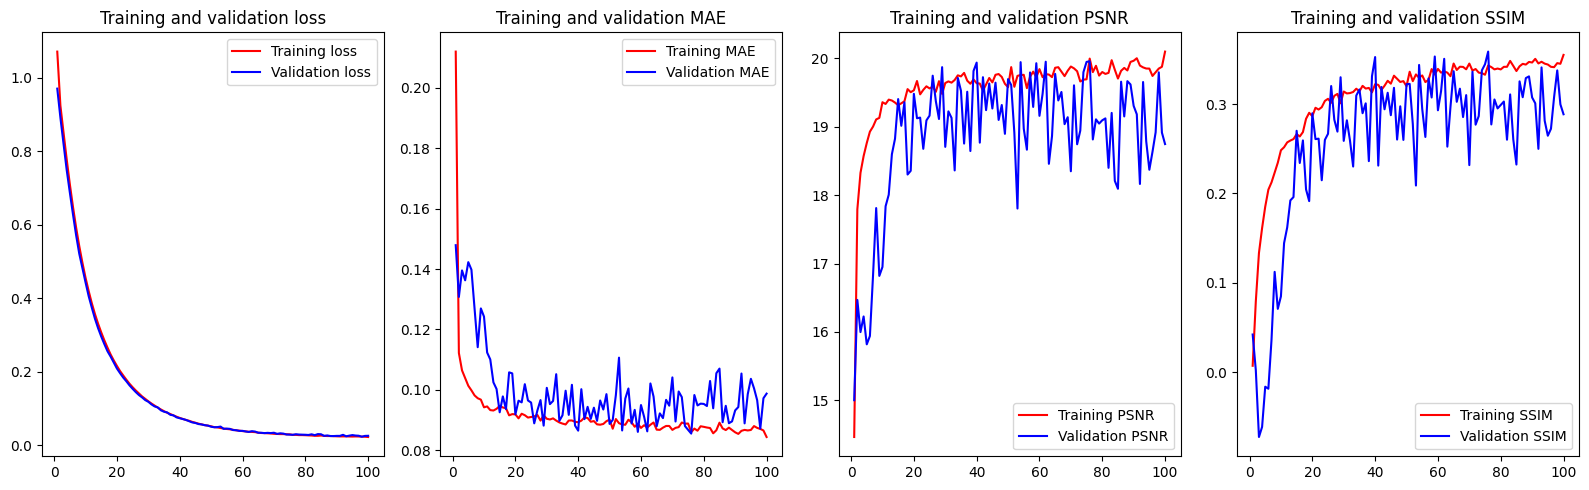

Time taken for denoising: 1342.323086977005 seconds


In [38]:

start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=  100 ,batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

# Modified structure of model:
1) Increased depth of the U-Net;
2) Residual connections;
3) use Dropout;
5) Combined Multiple Loss Functions.

In [50]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import backend as K
import tensorflow as tf

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg.trainable = False
feature_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer("block5_conv4").output)

def perceptual_loss(y_true, y_pred):
    y_true_rgb = K.repeat_elements(y_true, 3, axis=-1)
    y_pred_rgb = K.repeat_elements(y_pred, 3, axis=-1)

    y_true_features = feature_extractor(y_true_rgb)
    y_pred_features = feature_extractor(y_pred_rgb)
    
    return K.mean(K.square(y_true_features - y_pred_features))


def combined_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
    mae_loss = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred)
    perceptual = perceptual_loss(y_true, y_pred)
    return mse_loss + 0.1 * ssim_loss + 0.1 * mae_loss + 0.2 * perceptual


def unet(input_size=(128, 128, 1)):
    size_filter_in = 16
    kernel_init = 'he_normal'
    activation_layer = LeakyReLU()

    
    inputs = Input(input_size)
    conv_args = dict(padding='same', kernel_initializer=kernel_init, activation=activation_layer)

    conv1 = Conv2D(size_filter_in, 3, **conv_args)(inputs)
    conv1 = Conv2D(size_filter_in, 3, **conv_args)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.3)(pool1)

    conv2 = Conv2D(size_filter_in*2, 3, **conv_args)(drop1)
    conv2 = Conv2D(size_filter_in*2, 3, **conv_args)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.3)(pool2)

    conv3 = Conv2D(size_filter_in*4, 3, **conv_args)(drop2)
    conv3 = Conv2D(size_filter_in*4, 3, **conv_args)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.3)(pool3)

    conv4 = Conv2D(size_filter_in*8, 3, **conv_args)(drop3)
    conv4 = Conv2D(size_filter_in*8, 3, **conv_args)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, **conv_args)(pool4)
    conv5 = Conv2D(size_filter_in*16, 3, **conv_args)(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, **conv_args)(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    merge6 = Conv2D(size_filter_in*8, 1, padding='same')(merge6)
    conv6 = Conv2D(size_filter_in*8, 3, **conv_args)(merge6)
    conv6 = Conv2D(size_filter_in*8, 3, **conv_args)(conv6)
    residual6 = Add()([conv6, merge6])


    up7 = Conv2D(size_filter_in*4, 2, **conv_args)(UpSampling2D(size=(2, 2))(residual6))
    merge7 = concatenate([conv3, up7], axis=3)
    merge7 = Conv2D(size_filter_in*4, 1, padding='same')(merge7)
    conv7 = Conv2D(size_filter_in*4, 3, **conv_args)(merge7)
    conv7 = Conv2D(size_filter_in*4, 3, **conv_args)(conv7)
    residual7 = Add()([conv7, merge7])


    up8 = Conv2D(size_filter_in*2, 2, **conv_args)(UpSampling2D(size=(2, 2))(residual7))
    merge8 = concatenate([conv2, up8], axis=3)
    merge8 = Conv2D(size_filter_in*2, 1, padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(size_filter_in*2, 3, **conv_args)(merge8)
    conv8 = Conv2D(size_filter_in*2, 3, **conv_args)(conv8)
    residual8 = Add()([conv8, merge8])


    up9 = Conv2D(size_filter_in, 2, **conv_args)(UpSampling2D(size=(2, 2))(residual8))
    merge9 = concatenate([conv1, up9], axis=3)
    merge9 = Conv2D(size_filter_in, 1, padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(size_filter_in, 3, **conv_args)(merge9)
    conv9 = Conv2D(size_filter_in, 3, **conv_args)(conv9)
    residual9 = Add()([conv9, merge9])

    conv10 = Conv2D(1, 1, activation='tanh')(residual9)

    model = Model(inputs, conv10)
    model.compile(optimizer='adam', loss=combined_loss, metrics=['mae', 'psnr', 'ssim'])

    return model

In [ ]:
start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=100, batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

In [51]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def training_unet(path_save_spectrogram, weights_path, epochs, batch_size):
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPUs available: {len(gpus)}")

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")


    X_in = np.load(path_save_spectrogram + 'noisy_voice_amp_db.npy')
    X_ou = np.load(path_save_spectrogram + 'voice_amp_db.npy')
    X_ou = X_in - X_ou

    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    X_in = X_in[:, :, :]
    X_in = X_in.reshape(X_in.shape[0], X_in.shape[1], X_in.shape[2], 1)
    X_ou = X_ou[:, :, :]
    X_ou = X_ou.reshape(X_ou.shape[0], X_ou.shape[1], X_ou.shape[2], 1)

    X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.30, random_state=42)

    with strategy.scope():
        generator_nn = unet()


        checkpoint = ModelCheckpoint(
            weights_path + '/model_unet_best.keras', 
            verbose=1, 
            monitor='val_loss',
            save_best_only=True, 
            mode='auto'
        )

        generator_nn.compile(
            optimizer='adam', 
            loss=combined_loss, 
            metrics=[psnr, ssim, 'mae']
        )

    history = generator_nn.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=batch_size * strategy.num_replicas_in_sync, 
        shuffle=True,
        callbacks=[checkpoint], 
        verbose=1, 
        validation_data=(X_test, y_test)
    )

    plot_training_metrics(history)

GPUs available: 2
Number of devices: 2
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - loss: 1.1736 - mae: 0.9565 - psnr: 0.2272 - ssim: 0.0185
Epoch 1: val_loss improved from inf to 0.51041, saving model to ./weights/model_unet_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 1.1691 - mae: 0.9535 - psnr: 0.2509 - ssim: 0.0186 - val_loss: 0.5104 - val_mae: 0.4914 - val_psnr: 5.4589 - val_ssim: 0.0253
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - loss: 0.7070 - mae: 0.6389 - psnr: 3.4644 - ssim: 0.0076
Epoch 2: val_loss improved from 0.51041 to 0.18894, saving model to ./weights/model_unet_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.6924 - mae: 0.6276 - psnr: 3.6358 - ssim: 0.0081 - val_loss: 0.1889 - val_mae: 0.1982 - val_psnr: 12.1477 - val_ssim: 0.0201
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - loss: 0.2055 - mae: 0.2202 - psnr: 11.3280 - ssim: 0.0124
Epoch 3: val_loss did not improve from 0.18894
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/

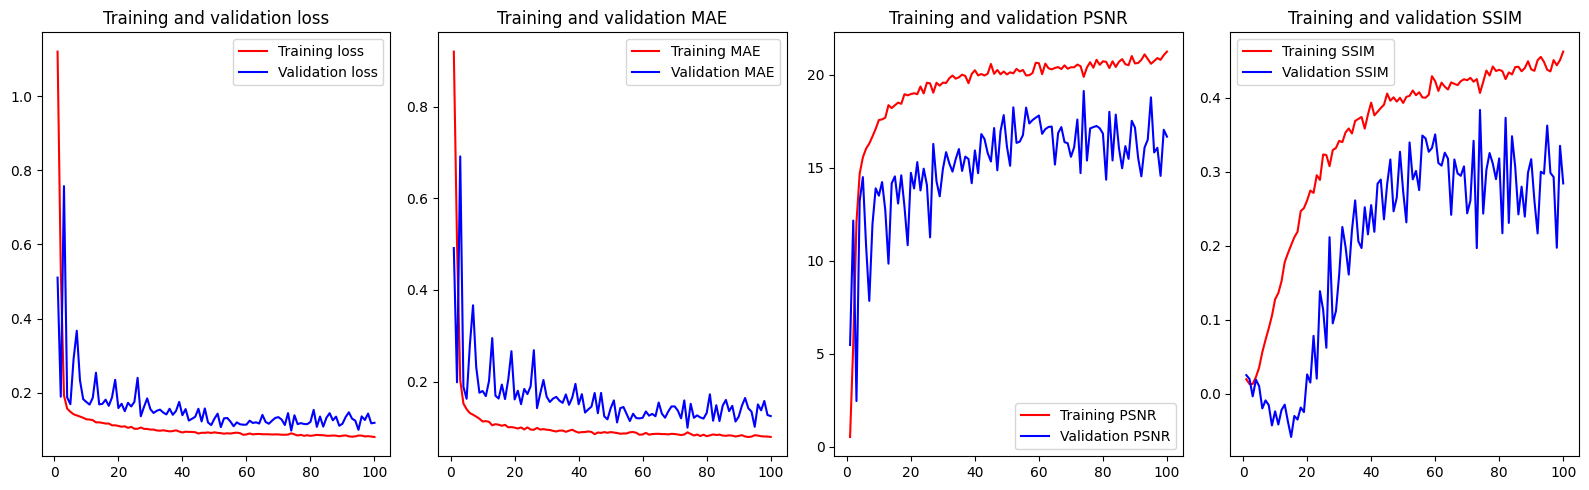

Time taken for denoising: 1109.1894037723541 seconds


In [41]:
start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=100, batch_size=64)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

In [34]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import losses

def residual_conv_block(x, filters, conv_args):
    shortcut = x
    x = Conv2D(filters, 3, **conv_args)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, 3, **conv_args)(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, **conv_args)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    return Add()([x, shortcut])

def attention_gate(skip, gate, filters):
    g = Conv2D(filters, 1, activation='relu')(gate)
    x = Conv2D(filters, 1, activation='relu')(skip)
    att = Add()([g, x])
    att = Conv2D(1, 1, activation='sigmoid')(att)
    return Multiply()([skip, att])

def unet_enhanced(input_size=(128, 128, 1)):
    size_filter_in = 32
    kernel_init = 'he_normal'
    activation_layer = LeakyReLU(alpha=0.1)
    dropout_rate = 0.3

    regularizer = l1_l2(l1=1e-5, l2=1e-4)

    inputs = Input(input_size)
    conv_args = dict(
        padding='same',
        kernel_initializer=kernel_init,
        activation=activation_layer,
        kernel_regularizer=regularizer
    )

    conv1 = residual_conv_block(inputs, size_filter_in, conv_args)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_conv_block(pool1, size_filter_in*2, conv_args)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_conv_block(pool2, size_filter_in*4, conv_args)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = residual_conv_block(pool3, size_filter_in*8, conv_args)
    conv4 = SpatialDropout2D(dropout_rate)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = residual_conv_block(pool4, size_filter_in*16, conv_args)
    conv5 = SpatialDropout2D(dropout_rate)(conv5)

    up6 = Conv2DTranspose(size_filter_in*8, 3, strides=2, padding='same')(conv5)
    att6 = attention_gate(conv4, up6, size_filter_in*8)
    merge6 = concatenate([att6, up6])
    conv6 = residual_conv_block(merge6, size_filter_in*8, conv_args)

    up7 = Conv2DTranspose(size_filter_in*4, 3, strides=2, padding='same')(conv6)
    att7 = attention_gate(conv3, up7, size_filter_in*4)
    merge7 = concatenate([att7, up7])
    conv7 = residual_conv_block(merge7, size_filter_in*4, conv_args)

    up8 = Conv2DTranspose(size_filter_in*2, 3, strides=2, padding='same')(conv7)
    att8 = attention_gate(conv2, up8, size_filter_in*2)
    merge8 = concatenate([att8, up8])
    conv8 = residual_conv_block(merge8, size_filter_in*2, conv_args)

    up9 = Conv2DTranspose(size_filter_in, 3, strides=2, padding='same')(conv8)
    att9 = attention_gate(conv1, up9, size_filter_in)
    merge9 = concatenate([att9, up9])
    conv9 = residual_conv_block(merge9, size_filter_in, conv_args)

    outputs = Conv2D(2, 1, activation='tanh', name='complex_output')(conv9)

    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=2000,
        decay_rate=0.95,
        staircase=True
    )

    optimizer = AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-4,
        global_clipnorm=1.0
    )

    model = Model(inputs, outputs)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae', 'mse']
    )
    
    return model

In [37]:
def combined_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mse = losses.mean_squared_error(y_true, y_pred)
    ssim_loss = 1 - tf.image.ssim(y_true, y_pred, max_val=2.0)
    return mse + 0.3 * ssim_loss

def ssim(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.image.ssim(y_true, y_pred, max_val=1.0)
    
def psnr(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
    
def training_unet(path_save_spectrogram, weights_path, epochs, batch_size):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPUs available: {len(gpus)}")
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")

    X_in = np.load(path_save_spectrogram + 'noisy_voice_amp_db.npy')
    X_ou = np.load(path_save_spectrogram + 'voice_amp_db.npy')
    
    X_ou_complex = np.stack([X_ou, X_in - X_ou], axis=-1)
    
    X_in = scaled_in(X_in)
    X_ou_complex = scaled_ou(X_ou_complex)

    X_in = X_in[..., np.newaxis]
    X_ou_complex = X_ou_complex

    X_train, X_test, y_train, y_test = train_test_split(
        X_in, X_ou_complex, 
        test_size=0.30, 
        random_state=42
    )

    with strategy.scope():
        generator_nn = unet_enhanced()

        checkpoint = ModelCheckpoint(
            weights_path + '/model_unet_best.keras',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=1
        )
        
        lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=1e-6
        )

        generator_nn.compile(
            optimizer=AdamW(
                learning_rate=1e-3,
                weight_decay=1e-4,
                global_clipnorm=1.0
            ),
            loss='mean_squared_error',
            metrics=[psnr, ssim, 'mae']
        )

    history = generator_nn.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size * strategy.num_replicas_in_sync,
        shuffle=True,
        callbacks=[checkpoint, lr_monitor],
        validation_data=(X_test, y_test),
        verbose=1
    )

    plot_training_metrics(history)
    tf.keras.backend.clear_session()
    return history

In [49]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
def unet(input_size=(128, 128, 1)):
    size_filter_in = 16
    kernel_init = 'he_normal'
    activation_layer = LeakyReLU()

    regularizer = l1_l2(l1=1e-5, l2=1e-4)  

    inputs = Input(input_size)
    conv_args = dict(padding='same', 
                     kernel_initializer=kernel_init, 
                     activation=activation_layer, 
                     kernel_regularizer=regularizer)

    conv1 = Conv2D(size_filter_in, 3, **conv_args)(inputs)
    conv1 = Conv2D(size_filter_in, 3, **conv_args)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(size_filter_in*2, 3, **conv_args)(pool1)
    conv2 = Conv2D(size_filter_in*2, 3, **conv_args)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(size_filter_in*4, 3, **conv_args)(pool2)
    conv3 = Conv2D(size_filter_in*4, 3, **conv_args)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(size_filter_in*8, 3, **conv_args)(pool3)
    conv4 = Conv2D(size_filter_in*8, 3, **conv_args)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, **conv_args)(pool4)
    conv5 = Conv2D(size_filter_in*16, 3, **conv_args)(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, **conv_args)(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(size_filter_in*8, 3, **conv_args)(merge6)
    conv6 = Conv2D(size_filter_in*8, 3, **conv_args)(conv6)

    up7 = Conv2D(size_filter_in*4, 2, **conv_args)(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(size_filter_in*4, 3, **conv_args)(merge7)
    conv7 = Conv2D(size_filter_in*4, 3, **conv_args)(conv7)

    up8 = Conv2D(size_filter_in*2, 2, **conv_args)(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(size_filter_in*2, 3, **conv_args)(merge8)
    conv8 = Conv2D(size_filter_in*2, 3, **conv_args)(conv8)

    up9 = Conv2D(size_filter_in, 2, **conv_args)(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(size_filter_in, 3, **conv_args)(merge9)
    conv9 = Conv2D(size_filter_in, 3, **conv_args)(conv9)

    conv10 = Conv2D(1, 1, activation='tanh')(conv9)
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = Adam(learning_rate=lr_schedule)
    model = Model(inputs, conv10)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    return model

In [53]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def training_unet(path_save_spectrogram, weights_path, epochs, batch_size):
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPUs available: {len(gpus)}")

    strategy = tf.distribute.MirroredStrategy()

    print(f"Number of devices: {strategy.num_replicas_in_sync}")

    X_in = np.load(path_save_spectrogram + 'noisy_voice_amp_db.npy')
    X_ou = np.load(path_save_spectrogram + 'voice_amp_db.npy')
    X_ou = X_in - X_ou

    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    X_in = X_in[:, :, :]
    X_in = X_in.reshape(X_in.shape[0], X_in.shape[1], X_in.shape[2], 1)
    X_ou = X_ou[:, :, :]
    X_ou = X_ou.reshape(X_ou.shape[0], X_ou.shape[1], X_ou.shape[2], 1)

    X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.30, random_state=42)

    with strategy.scope():
        generator_nn = unet()

        checkpoint = ModelCheckpoint(
            weights_path + '/model_unet_best.keras', 
            verbose=1, 
            monitor='val_loss',
            save_best_only=True, 
            mode='auto'
        )

        generator_nn.compile(
            optimizer='adam', 
            loss='mean_squared_error', 
            metrics=[psnr, ssim, 'mae']
        )

    history = generator_nn.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=batch_size * strategy.num_replicas_in_sync,
        shuffle=True,
        callbacks=[checkpoint], 
        verbose=1, 
        validation_data=(X_test, y_test)
    )

    plot_training_metrics(history)


def plot_training_metrics(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    psnr_values = history.history['psnr']
    val_psnr_values = history.history['val_psnr']
    ssim_values = history.history['ssim']
    val_ssim_values = history.history['val_ssim']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 4, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs, mae, 'r', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(epochs, psnr_values, 'r', label='Training PSNR')
    plt.plot(epochs, val_psnr_values, 'b', label='Validation PSNR')
    plt.title('Training and validation PSNR')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs, ssim_values, 'r', label='Training SSIM')
    plt.plot(epochs, val_ssim_values, 'b', label='Validation SSIM')
    plt.title('Training and validation SSIM')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
start_time = time.time()

training_unet(path_save_spectrogram, './weights', epochs=200, batch_size=32)

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for denoising:", elapsed_time, "seconds")

GPUs available: 2
Number of devices: 2
Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 1.1599 - mae: 0.3120 - psnr: 11.0838 - ssim: 0.0120
Epoch 1: val_loss improved from inf to 0.94121, saving model to ./weights/model_unet_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - loss: 1.1577 - mae: 0.3098 - psnr: 11.1488 - ssim: 0.0123 - val_loss: 0.9412 - val_mae: 0.1105 - val_psnr: 17.7178 - val_ssim: 0.0827
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.9190 - mae: 0.1116 - psnr: 17.7224 - ssim: 0.0822
Epoch 2: val_loss improved from 0.94121 to 0.84869, saving model to ./weights/model_unet_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - loss: 0.9186 - mae: 0.1116 - psnr: 17.7232 - ssim: 0.0823 - val_loss: 0.8487 - val_mae: 0.1113 - val_psnr: 17.8283 - val_ssim: 0.0694
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.8268 - mae: 0.1088 - psnr: 18.0227 - ssim: 0.1205
Epoch 3: val_loss improved from 0.84869 to 0.75763, saving model to ./w

In [35]:
!pip install pesq
!pip install --upgrade librosa

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262948 sha256=5f4122a0f99528f536562a7ccc726f018c944b88d3ea5532cdf59604f686d071
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 7.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.2.post1
    Uninstalling librosa-0.10.2.post1:
      Successfully uninstalled librosa-0.10.2.post1


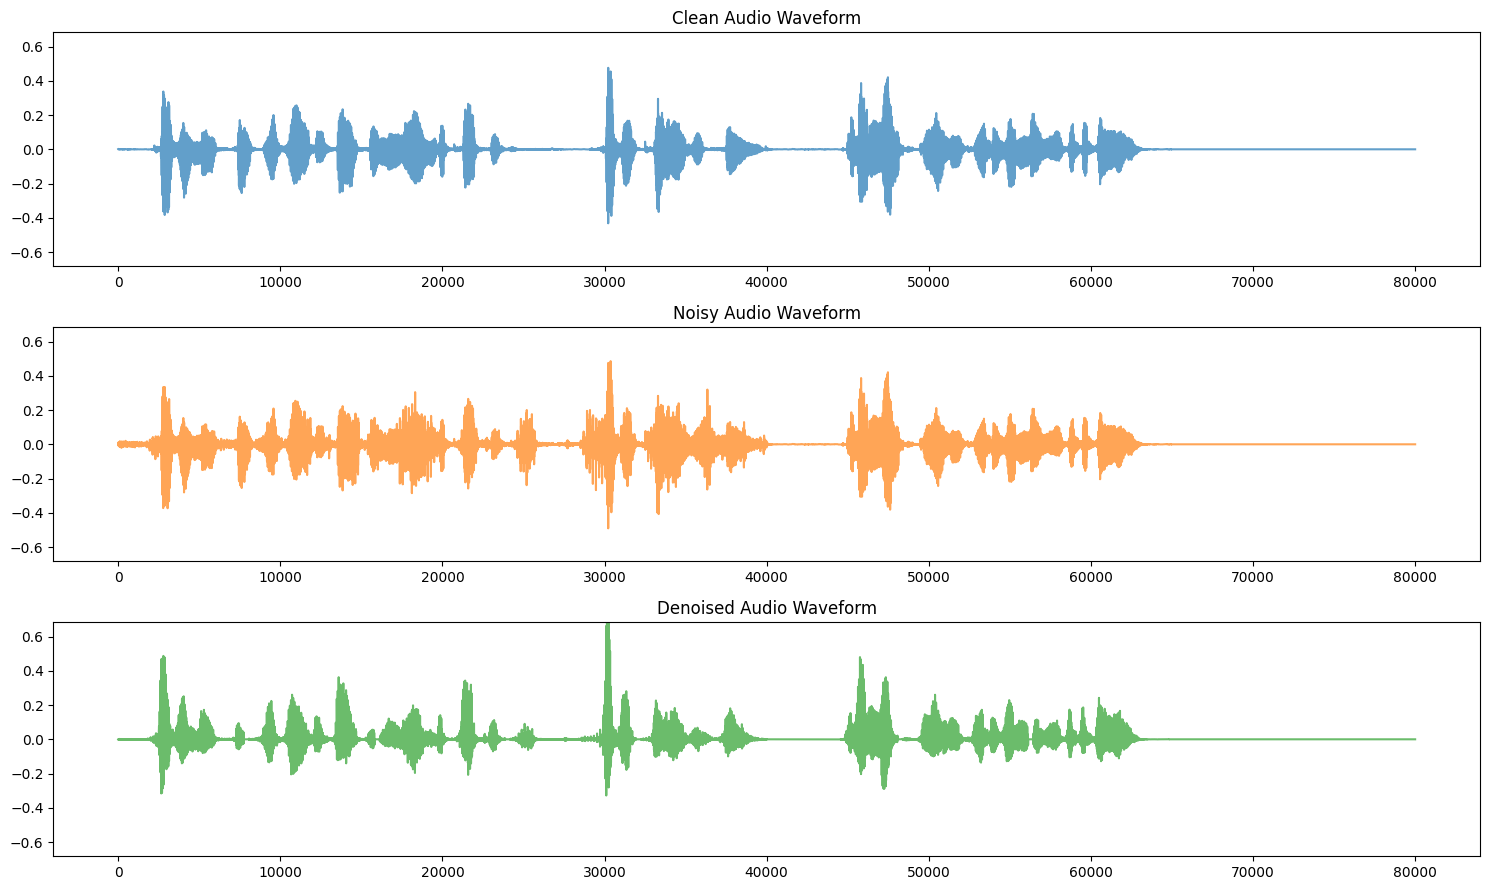

Clean Audio:


Noisy Audio:


Denoised Audio:



PESQ Score: 2.00


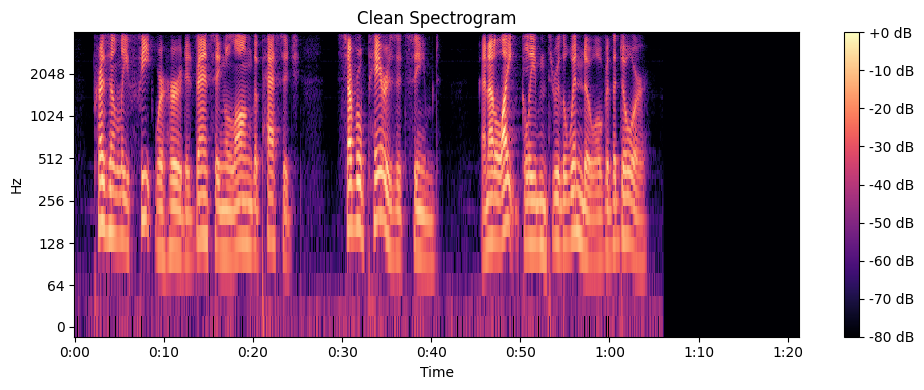

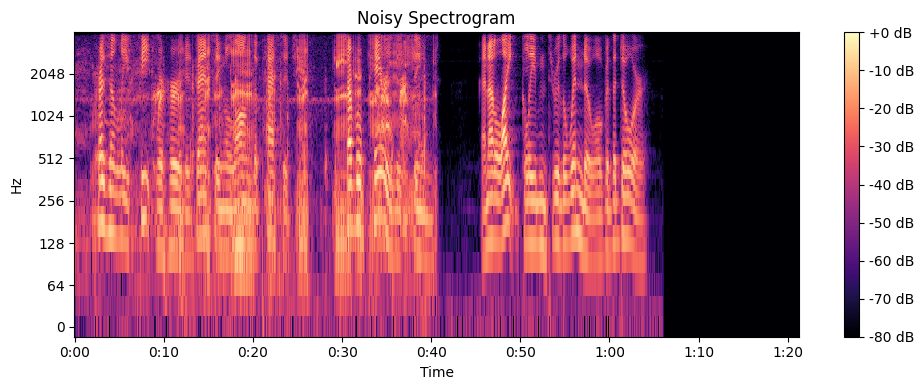

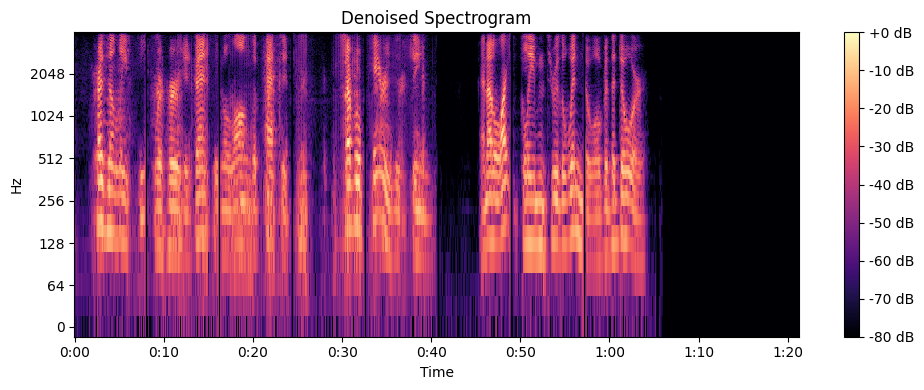

In [40]:
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from pesq import pesq
from IPython.display import Audio, display
import os
import random
import tensorflow as tf

def scaled_in(matrix_spec):
    return (matrix_spec + 46) / 50

def scaled_ou(matrix_spec):
    return (matrix_spec - 6) / 82

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

model = tf.keras.models.load_model(
    './weights/model_unet_best.keras',
    custom_objects={
        'LeakyReLU': tf.keras.layers.LeakyReLU,
        'psnr': psnr,
        'ssim': ssim
    }
)

sample_rate = 8000
n_fft, hop_length_fft = 255, 63
duration = 10
target_length = duration * sample_rate

clean_dir = "/kaggle/working/clean_speech"
clean_files = [os.path.join(clean_dir, f) for f in os.listdir(clean_dir) if f.endswith('.flac')]
clean_path = random.choice(clean_files)
clean, _ = librosa.load(clean_path, sr=sample_rate)
clean = librosa.util.fix_length(clean, size=target_length)

noise_dir = "/kaggle/working/noise"
noise_files = [os.path.join(noise_dir, f) for f in os.listdir(noise_dir) if f.endswith('.wav')]
noise, _ = librosa.load(random.choice(noise_files), sr=sample_rate)
noise = librosa.util.fix_length(noise, size=target_length)
noise_level = np.random.uniform(0.2, 0.8)
noisy = clean + noise_level * noise

def process_frame(frame):
    S_noisy = librosa.stft(frame, n_fft=n_fft, hop_length=hop_length_fft, center=False)
    magnitude_noisy, phase = librosa.magphase(S_noisy)

    ref_val = np.max(magnitude_noisy)
    magnitude_noisy_db = librosa.amplitude_to_db(magnitude_noisy, ref=ref_val)
    F, T = magnitude_noisy_db.shape
    pad_T = 128 - T
    if pad_T > 0:
        magnitude_noisy_db = np.pad(magnitude_noisy_db, ((0, 0), (0, pad_T)), mode="constant")
    else:
        magnitude_noisy_db = magnitude_noisy_db[:, :128]

    X_in = scaled_in(magnitude_noisy_db)[None, ..., None].astype(np.float32)
    pred_noise_db = model.predict(X_in, verbose=0)[0, ..., 0]
    pred_noise_db = pred_noise_db * 82 + 6

    pred_noise_db = pred_noise_db[:, :T]

    clean_db = magnitude_noisy_db[:, :T] - pred_noise_db

    clean_magnitude = librosa.db_to_amplitude(clean_db, ref=ref_val)

    return librosa.istft(clean_magnitude * np.exp(1j * phase), hop_length=hop_length_fft)


def pad_or_trim(y, length):
    if len(y) > length:
        return y[:length]
    elif len(y) < length:
        return np.pad(y, (0, length - len(y)), mode='constant')
    return y


def plot_spec(signal, title):
    S = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length_fft)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()


frame_length = 8064
denoised = np.zeros_like(noisy)

for i in range(0, len(noisy), frame_length):
    frame = noisy[i:i+frame_length]
    denoised_frame = process_frame(frame)
    denoised_frame_fixed = pad_or_trim(denoised_frame, len(frame))
    denoised[i:i+len(frame)] = denoised_frame_fixed


try:
    pesq_score = pesq(sample_rate, clean, denoised, 'nb')
except Exception as e:
    pesq_score = None
    print("PESQ Error:", e)


max_amp = max(
    np.max(np.abs(clean)),
    np.max(np.abs(noisy)),
    np.max(np.abs(denoised))
) + 1e-9 

plt.figure(figsize=(15, 9))

plt.subplot(3, 1, 1)
plt.plot(clean, color='#1f77b4', alpha=0.7)
plt.ylim(-max_amp, max_amp)
plt.title("Clean Audio Waveform")

plt.subplot(3, 1, 2)
plt.plot(noisy, color='#ff7f0e', alpha=0.7)
plt.ylim(-max_amp, max_amp)
plt.title("Noisy Audio Waveform")

plt.subplot(3, 1, 3)
plt.plot(denoised, color='#2ca02c', alpha=0.7)
plt.ylim(-max_amp, max_amp)
plt.title("Denoised Audio Waveform")

plt.tight_layout()
plt.show()


plot_spec(clean, "Clean Spectrogram")
plot_spec(noisy, "Noisy Spectrogram")
plot_spec(denoised, "Denoised Spectrogram")

max_val = max(np.max(np.abs(clean)), np.max(np.abs(denoised))) + 1e-9
print("Clean Audio:")
display(Audio(clean / max_val, rate=sample_rate))
print("Noisy Audio:")
display(Audio(noisy / max_val, rate=sample_rate))
print("Denoised Audio:")
display(Audio(denoised / max_val, rate=sample_rate))

if pesq_score:
    print(f"\nPESQ Score: {pesq_score:.2f}")

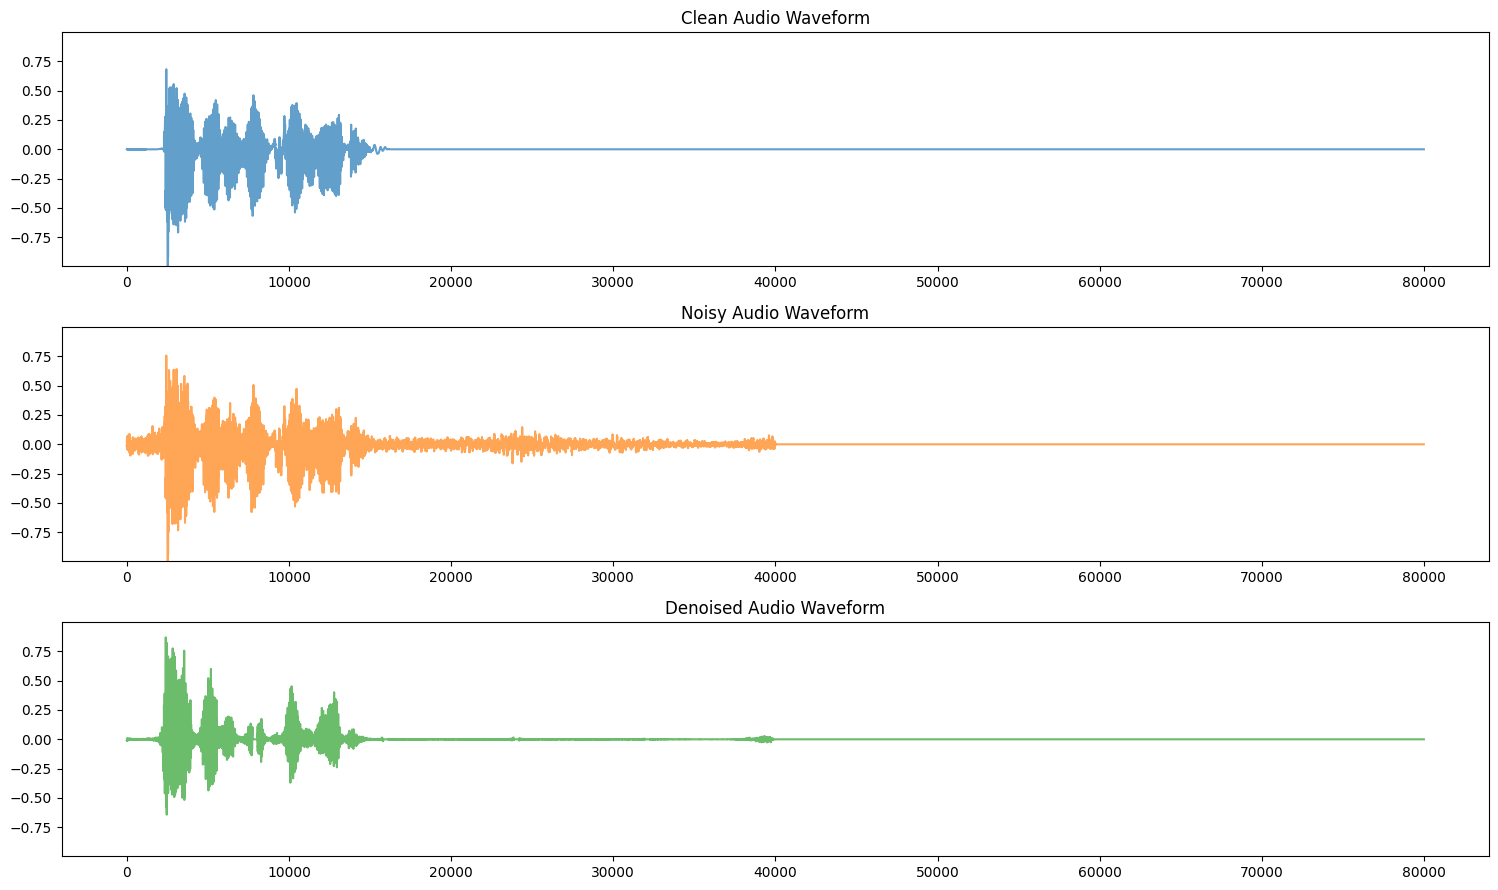

Clean Audio:


Noisy Audio:


Denoised Audio:



PESQ Score: 2.32


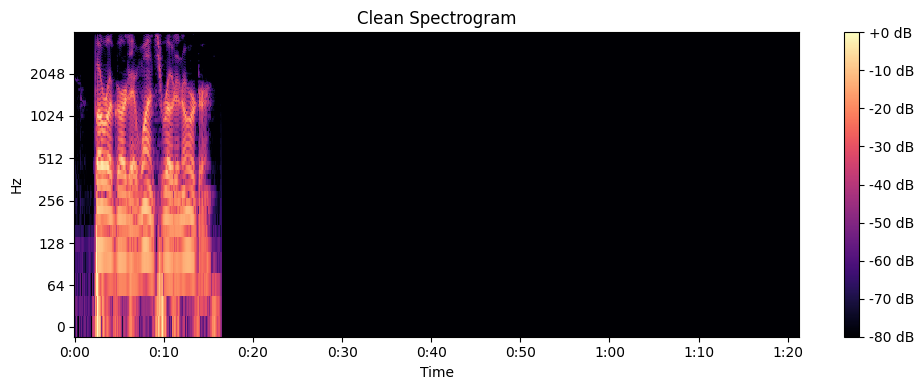

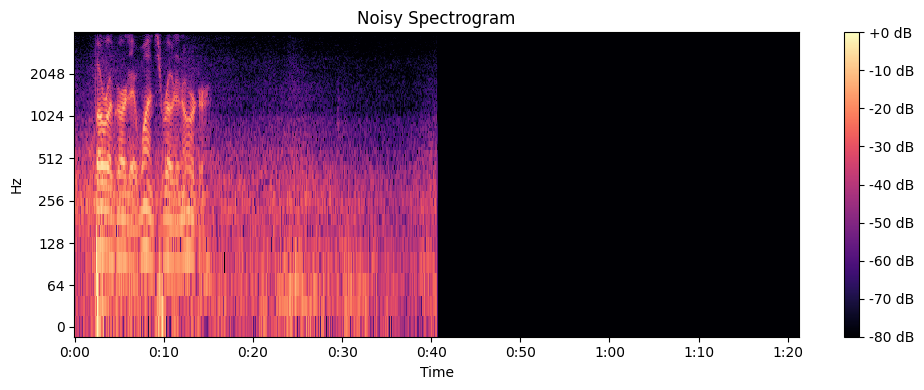

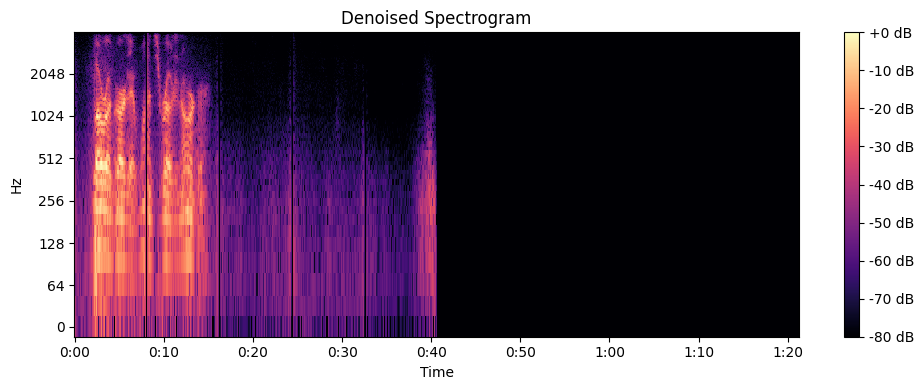

In [41]:
sample_rate = 8000
n_fft, hop_length_fft = 255, 63
duration = 10
target_length = duration * sample_rate

clean_dir = "/kaggle/working/clean_speech"
clean_files = [os.path.join(clean_dir, f) for f in os.listdir(clean_dir) if f.endswith('.flac')]
clean_path = random.choice(clean_files)
clean, _ = librosa.load(clean_path, sr=sample_rate)
clean = librosa.util.fix_length(clean, size=target_length)

noise_dir = "/kaggle/working/noise"
noise_files = [os.path.join(noise_dir, f) for f in os.listdir(noise_dir) if f.endswith('.wav')]
noise, _ = librosa.load(random.choice(noise_files), sr=sample_rate)
noise = librosa.util.fix_length(noise, size=target_length)
noise_level = np.random.uniform(0.2, 0.8)
noisy = clean + noise_level * noise

frame_length = 8064
denoised = np.zeros_like(noisy)

for i in range(0, len(noisy), frame_length):
    frame = noisy[i:i+frame_length]
    denoised_frame = process_frame(frame)
    denoised_frame_fixed = pad_or_trim(denoised_frame, len(frame))
    denoised[i:i+len(frame)] = denoised_frame_fixed


try:
    pesq_score = pesq(sample_rate, clean, denoised, 'nb')
except Exception as e:
    pesq_score = None
    print("PESQ Error:", e)


max_amp = max(
    np.max(np.abs(clean)),
    np.max(np.abs(noisy)),
    np.max(np.abs(denoised))
) + 1e-9 

plt.figure(figsize=(15, 9))

plt.subplot(3, 1, 1)
plt.plot(clean, color='#1f77b4', alpha=0.7)
plt.ylim(-max_amp, max_amp)
plt.title("Clean Audio Waveform")

plt.subplot(3, 1, 2)
plt.plot(noisy, color='#ff7f0e', alpha=0.7)
plt.ylim(-max_amp, max_amp)
plt.title("Noisy Audio Waveform")

plt.subplot(3, 1, 3)
plt.plot(denoised, color='#2ca02c', alpha=0.7)
plt.ylim(-max_amp, max_amp)
plt.title("Denoised Audio Waveform")

plt.tight_layout()
plt.show()


plot_spec(clean, "Clean Spectrogram")
plot_spec(noisy, "Noisy Spectrogram")
plot_spec(denoised, "Denoised Spectrogram")

max_val = max(np.max(np.abs(clean)), np.max(np.abs(denoised))) + 1e-9
print("Clean Audio:")
display(Audio(clean / max_val, rate=sample_rate))
print("Noisy Audio:")
display(Audio(noisy / max_val, rate=sample_rate))
print("Denoised Audio:")
display(Audio(denoised / max_val, rate=sample_rate))

if pesq_score:
    print(f"\nPESQ Score: {pesq_score:.2f}")